# Detecting patterns of speciation in the fos- sil record

In this assignment, we use data from the NOW (New and Old Worlds) database of fossil mammals to study patterns of speciation over time and space. In particular, we are interested to know when and where speciation rates have been significantly high. The task is to find which time periods and which places over the history of mammals have given rise to exceptionally high numbers of new species. The phenomenon is known in the evolutionary literature as the “species factory”. Palaeontologists are interested why and in which ways those times and places are special. The role of computational science is to identify and characterize such times and places.
We practice using pandas DataFrames, performing logistic regression and making statistical significance tests in data analysis.

In [57]:
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.cm as cm
import matplotlib.colors as mcolors


pd.options.display.max_columns = None
pd.options.display.min_rows = 10
pd.options.mode.copy_on_write = True


Exercise 1. Download data from the NOW database. Go to
    http://www.helsinki.fi/science/now/
    Click “View Database”, then “Enter Database”, then “Locality” and then
    “Export”. Select “include species lists” and choose “Comma” for field
    separator. Then, click “All NOW localities”. Once download completes,
    copy all of the text on your browser and paste it into a new txt file. Save
    the file.
    Once we have all of the raw data, we need to transform it into a more useful
    format.
Exercise 2. Create a pandas DataFrame that contains all of the data
    and save it as a csv file. How many rows does the DataFrame contain?

In [58]:
df = pd.read_csv(r'raw.txt', sep=',')
df.to_csv('dataframe.csv')

print(f'Dataframe has {df.shape[0]} rows and {df.shape[1]} columns')
df

Dataframe has 83325 rows and 102 columns


LIDNUM        NAME      LATSTR      LONGSTR        LAT        LONG  \
0       21390       Aarau   47 23 0 N      8 3 0 E  47.383000    8.050000   
1       29029   Aarwangen  47 14 37 N    7 45 21 E  47.243654    7.755959   
2       27232   Aba Zawei  33 15 00 N  102 25 00 E  33.250000  102.416667   
3       27232   Aba Zawei  33 15 00 N  102 25 00 E  33.250000  102.416667   
4       27232   Aba Zawei  33 15 00 N  102 25 00 E  33.250000  102.416667   
...       ...         ...         ...          ...        ...         ...   
83320   22144  Zyrjanovsk   49 27 0 N    84 9 36 E  49.450000   84.160000   
83321   22144  Zyrjanovsk   49 27 0 N    84 9 36 E  49.450000   84.160000   
83322   22144  Zyrjanovsk   49 27 0 N    84 9 36 E  49.450000   84.160000   
83323   22144  Zyrjanovsk   49 27 0 N    84 9 36 E  49.450000   84.160000   
83324   22144  Zyrjanovsk   49 27 0 N    84 9 36 E  49.450000   84.160000   

      ALTITUDE  MAX_AGE          BFA_MAX BFA_MAX_ABS FRAC_MAX  MIN_AGE  \
0           \N  14.2000              mn6          \N       \N  12.8500   
1           \N  25.4100             mp27          \N       \N  24.5600   
2           \N   0.0295               \N         C14       \N   0.0235   
3           \N   0.0295               \N         C14       \N   0.0235   
4           \N   0.0295               \N         C14       \N   0.0235   
...        ...      ...              ...         ...      ...      ...   
83320       \N   0.1290  latepleistocene          \N       \N   0.0117   
83321       \N   0.1290  latepleistocene          \N       \N   0.0117   
83322       \N   0.1290  latepleistocene          \N       \N   0.0117   
83323       \N   0.1290  latepleistocene          \N       \N   0.0117   
83324       \N   0.1290  latepleistocene          \N       \N   0.0117   

               BFA_MIN BFA_MIN_ABS FRAC_MIN             CHRON  \
0                  mn6          \N       \N               NaN   
1                 mp27          \N       \N                \N   
2                   \N         C14       \N                \N   
3                   \N         C14       \N                \N   
4                   \N         C14       \N                \N   
...                ...         ...      ...               ...   
83320  latepleistocene          \N       \N  Late Pleistocene   
83321  latepleistocene          \N       \N  Late Pleistocene   
83322  latepleistocene          \N       \N  Late Pleistocene   
83323  latepleistocene          \N       \N  Late Pleistocene   
83324  latepleistocene          \N       \N  Late Pleistocene   

                            AGE_COMM    BASIN SUBBASIN      COUNTRY  \
0                                NaN  Molasse       \N  Switzerland   
1                                 \N       \N       \N  Switzerland   
2                                C14       \N       \N        China   
3                                C14       \N       \N        China   
4                                C14       \N       \N        China   
...                              ...      ...      ...          ...   
83320  AG3 Upper Paleolithic complex       \N       \N   Kazakhstan   
83321  AG3 Upper Paleolithic complex       \N       \N   Kazakhstan   
83322  AG3 Upper Paleolithic complex       \N       \N   Kazakhstan   
83323  AG3 Upper Paleolithic complex       \N       \N   Kazakhstan   
83324  AG3 Upper Paleolithic complex       \N       \N   Kazakhstan   

              STATE COUNTY APNUMSPM GENERAL LOC_SYNONYMS MEAN_HYPSODONTY  \
0               NaN    NaN       \N     NaN           \N              \N   
1                \N     \N       \N      \N           \N            1.00   
2           Sichuan    Aba       \N       n           \N            3.00   
3           Sichuan    Aba       \N       n           \N            3.00   
4           Sichuan    Aba       \N       n           \N            3.00   
...             ...    ...      ...     ...          ...             ...   
83320  r. Vtorushka    NaN 

Exercise 3. a) Remove all rows where LAT = LONG = 0
    these occurrences have incorrect coordinates. Drop rows where SPECIES is “sp.” or
    “indet.”; these occurrences have not been properly identified.


In [59]:
df = df[(df['LAT'] != 0) & (df['LONG'] != 0)]
df = df[(df['SPECIES'] != 'sp.') & (df['SPECIES'] != 'indet.')]
df

LIDNUM        NAME      LATSTR      LONGSTR        LAT        LONG  \
0       21390       Aarau   47 23 0 N      8 3 0 E  47.383000    8.050000   
1       29029   Aarwangen  47 14 37 N    7 45 21 E  47.243654    7.755959   
3       27232   Aba Zawei  33 15 00 N  102 25 00 E  33.250000  102.416667   
4       27232   Aba Zawei  33 15 00 N  102 25 00 E  33.250000  102.416667   
5       27232   Aba Zawei  33 15 00 N  102 25 00 E  33.250000  102.416667   
...       ...         ...         ...          ...        ...         ...   
83320   22144  Zyrjanovsk   49 27 0 N    84 9 36 E  49.450000   84.160000   
83321   22144  Zyrjanovsk   49 27 0 N    84 9 36 E  49.450000   84.160000   
83322   22144  Zyrjanovsk   49 27 0 N    84 9 36 E  49.450000   84.160000   
83323   22144  Zyrjanovsk   49 27 0 N    84 9 36 E  49.450000   84.160000   
83324   22144  Zyrjanovsk   49 27 0 N    84 9 36 E  49.450000   84.160000   

      ALTITUDE  MAX_AGE          BFA_MAX BFA_MAX_ABS FRAC_MAX  MIN_AGE  \
0           \N  14.2000              mn6          \N       \N  12.8500   
1           \N  25.4100             mp27          \N       \N  24.5600   
3           \N   0.0295               \N         C14       \N   0.0235   
4           \N   0.0295               \N         C14       \N   0.0235   
5           \N   0.0295               \N         C14       \N   0.0235   
...        ...      ...              ...         ...      ...      ...   
83320       \N   0.1290  latepleistocene          \N       \N   0.0117   
83321       \N   0.1290  latepleistocene          \N       \N   0.0117   
83322       \N   0.1290  latepleistocene          \N       \N   0.0117   
83323       \N   0.1290  latepleistocene          \N       \N   0.0117   
83324       \N   0.1290  latepleistocene          \N       \N   0.0117   

               BFA_MIN BFA_MIN_ABS FRAC_MIN             CHRON  \
0                  mn6          \N       \N               NaN   
1                 mp27          \N       \N                \N   
3                   \N         C14       \N                \N   
4                   \N         C14       \N                \N   
5                   \N         C14       \N                \N   
...                ...         ...      ...               ...   
83320  latepleistocene          \N       \N  Late Pleistocene   
83321  latepleistocene          \N       \N  Late Pleistocene   
83322  latepleistocene          \N       \N  Late Pleistocene   
83323  latepleistocene          \N       \N  Late Pleistocene   
83324  latepleistocene          \N       \N  Late Pleistocene   

                            AGE_COMM    BASIN SUBBASIN      COUNTRY  \
0                                NaN  Molasse       \N  Switzerland   
1                                 \N       \N       \N  Switzerland   
3                                C14       \N       \N        China   
4                                C14       \N       \N        China   
5                                C14       \N       \N        China   
...                              ...      ...      ...          ...   
83320  AG3 Upper Paleolithic complex       \N       \N   Kazakhstan   
83321  AG3 Upper Paleolithic complex       \N       \N   Kazakhstan   
83322  AG3 Upper Paleolithic complex       \N       \N   Kazakhstan   
83323  AG3 Upper Paleolithic complex       \N       \N   Kazakhstan   
83324  AG3 Upper Paleolithic complex       \N       \N   Kazakhstan   

              STATE COUNTY APNUMSPM GENERAL LOC_SYNONYMS MEAN_HYPSODONTY  \
0               NaN    NaN       \N     NaN           \N              \N   
1                \N     \N       \N      \N           \N            1.00   
3           Sichuan    Aba       \N       n           \N            3.00   
4           Sichuan    Aba       \N       n           \N            3.00   
5           Sichuan    Aba       \N       n           \N            3.00   
...             ...    ...      ...     ...          ...             ...   
83320  r. Vtorushka    NaN 

b) Next we will assign each occurrence to a specific Mammal Neogene
(MN) time unit. Table 1 shows the time boundaries of each time unit.
Assign each occurrence to a correct time unit by calculating the mean of
MIN AGE and MAX AGE. If the mean age of an occurrence is precisely
on the boundary between two time units, assign the occurrence to the
older time unit. If the mean age of an occurrence is outside of the MN
time interval, assign it to a “pre-MN” or “post-MN” category.


In [60]:
mn_df = pd.DataFrame(data = {
    "mn": ["MN1", "MN2", "MN3", "MN4", "MN5", "MN6", "MN7-8", "MN9", "MN10", 
           "MN11", "MN12", "MN13", "MN14", "MN15", "MN16", "MN17", "MQ18", "MQ19"],
    "max": [23.0, 21.7, 19.5, 17.2, 16.4, 14.2, 12.85, 11.2, 9.9, 8.9, 7.6, 7.1, 5.3, 5.0, 3.55, 2.5, 1.9, 0.85],
    "min": [21.7, 19.5, 17.2, 16.4, 14.2, 12.85, 11.2, 9.9, 8.9, 7.6, 7.1, 5.3, 5.0, 3.55, 2.5, 1.9, 0.85, 0.01]
})

In [61]:
df['mean'] = (df['MIN_AGE'] + df['MAX_AGE'])/2


In [62]:
def getMN(x):
    if(x['mean'] > 23): return ('pre-MN', 0)
    for index, row in mn_df.iterrows():
        if(row['max'] > x['mean'] >= row['min']): return (row['mn'], index +1)
    else: return ('post-MN', 19)

#The MN_INDEX is used later to ease the processing.
df[['MN', 'MN_INDEX']] = df.apply(getMN,  axis=1, result_type='expand')

df[['MN', 'MN_INDEX']]

MN  MN_INDEX
0         MN6         6
1      pre-MN         0
3        MQ19        18
4        MQ19        18
5        MQ19        18
...       ...       ...
83320    MQ19        18
83321    MQ19        18
83322    MQ19        18
83323    MQ19        18
83324    MQ19        18

[61649 rows x 2 columns]

c) Sometimes expert knowledge may be used to override some of the
    information recorded in the data. In our case, experts in palaeontology
    tell us that occurrences in the localities “Samos Main Bone Beds” and
    “Can Llobateres I” should be assigned to time units MN12 and MN9,
    respectively. Check these and if necessary, edit the time units to their
    correct values.

In [63]:
df.loc[df['NAME'] == 'Samos Main Bone Beds', 'MN'] = 'MN12'
df.loc[df['NAME'] == 'Can Llobateres 1', 'MN'] = 'MN9'
temp = df.loc[df['NAME'] == 'Can Llobateres 1', :]
temp

LIDNUM              NAME      LATSTR   LONGSTR        LAT     LONG  \
8912   20020  Can Llobateres 1  41 31 57 N  2 8 12 E  41.532663  2.13691   
8913   20020  Can Llobateres 1  41 31 57 N  2 8 12 E  41.532663  2.13691   
8914   20020  Can Llobateres 1  41 31 57 N  2 8 12 E  41.532663  2.13691   
8915   20020  Can Llobateres 1  41 31 57 N  2 8 12 E  41.532663  2.13691   
8917   20020  Can Llobateres 1  41 31 57 N  2 8 12 E  41.532663  2.13691   
...      ...               ...         ...       ...        ...      ...   
8980   20020  Can Llobateres 1  41 31 57 N  2 8 12 E  41.532663  2.13691   
8983   20020  Can Llobateres 1  41 31 57 N  2 8 12 E  41.532663  2.13691   
8985   20020  Can Llobateres 1  41 31 57 N  2 8 12 E  41.532663  2.13691   
8986   20020  Can Llobateres 1  41 31 57 N  2 8 12 E  41.532663  2.13691   
8987   20020  Can Llobateres 1  41 31 57 N  2 8 12 E  41.532663  2.13691   

     ALTITUDE  MAX_AGE  BFA_MAX BFA_MAX_ABS FRAC_MAX  MIN_AGE  BFA_MIN  \
8912       \N    9.786  c4ar.3r          \N       \N    9.721  c4ar.3r   
8913       \N    9.786  c4ar.3r          \N       \N    9.721  c4ar.3r   
8914       \N    9.786  c4ar.3r          \N       \N    9.721  c4ar.3r   
8915       \N    9.786  c4ar.3r          \N       \N    9.721  c4ar.3r   
8917       \N    9.786  c4ar.3r          \N       \N    9.721  c4ar.3r   
...       ...      ...      ...         ...      ...      ...      ...   
8980       \N    9.786  c4ar.3r          \N       \N    9.721  c4ar.3r   
8983       \N    9.786  c4ar.3r          \N       \N    9.721  c4ar.3r   
8985       \N    9.786  c4ar.3r          \N       \N    9.721  c4ar.3r   
8986       \N    9.786  c4ar.3r          \N       \N    9.721  c4ar.3r   
8987       \N    9.786  c4ar.3r          \N       \N    9.721  c4ar.3r   

     BFA_MIN_ABS FRAC_MIN CHRON  \
8912          \N       \N  MN 9   
8913          \N       \N  MN 9   
8914          \N       \N  MN 9   
8915          \N       \N  MN 9   
8917          \N       \N  MN 9   
...          ...      ...   ...   
8980          \N       \N  MN 9   
8983          \N       \N  MN 9   
8985          \N       \N  MN 9   
8986          \N       \N  MN 9   
8987          \N       \N  MN 9   

                                               AGE_COMM            BASIN  \
8912  MN9(reference site).Cricetulodon hartenbergeri...  Valencia Trough   
8913  MN9(reference site).Cricetulodon hartenbergeri...  Valencia Trough   
8914  MN9(reference site).Cricetulodon hartenbergeri...  Valencia Trough   
8915  MN9(reference site).Cricetulodon hartenbergeri...  Valencia Trough   
8917  MN9(reference site).Cricetulodon hartenbergeri...  Valencia Trough   
...                                                 ...              ...   
8980  MN9(reference site).Cricetulodon hartenbergeri...  Valencia Trough   
8983  MN9(reference site).Cricetulodon hartenbergeri...  Valencia Trough   
8985  MN9(reference site).Cricetulodon hartenbergeri...  Valencia Trough   
8986  MN9(reference site).Cricetulodon hartenbergeri...  Valencia Trough   
8987  MN9(reference site).Cricetulodon hartenbergeri...  Valencia Trough   

                  SUBBASIN COUNTRY      STATE             COUNTY APNUMSPM  \
8912  Vallès-Penedès Basin   Spain  Catalonia  Vallès Occidental       \N   
8913  Vallès-Penedès Basin   Spain  Catalonia  Vallès Occidental       \N   
8914  Vallès-Penedès Basin   Spain  Catalonia  Vallès Occidental       \N   
8915  Vallès-Penedès Basin   Spain  Catalonia  Vallès Occidental       \N   
8917  Vallès-Penedès Basin   Spain  Catalonia  Vallès Occidental       \N   
...                    ...     ...        ...                ...      ...   
8980  Vallès-Penedès Basin   Spain  Catalonia  Vallès Occidental       \N   
8983  Vallès-Penedès Basin   Spain  Catalonia  Vallès Occidental       \N   
8985  Vallès-Penedès Basin   Spain  Catalonia  Vallès Occidental       \N   
8986  Vallès-Penedès Basin   Spain  Catalonia  Vallès Occidental       \N   
8987  Vallès-Penedès Ba

d) We need to be able to identify all occurrences of each species. Assign
    a unique identification number for each unique combination of GENUS
    and SPECIES. Create a new column in the DataFrame and label each
    occurrence with a corresponding species identification number.

In [64]:
df['SIN'] = df.groupby(['GENUS', 'SPECIES']).ngroup()+1 #ngroup starts from 0, SIN = species identification number
print(df['SIN'].max()) 
df

11250


LIDNUM        NAME      LATSTR      LONGSTR        LAT        LONG  \
0       21390       Aarau   47 23 0 N      8 3 0 E  47.383000    8.050000   
1       29029   Aarwangen  47 14 37 N    7 45 21 E  47.243654    7.755959   
3       27232   Aba Zawei  33 15 00 N  102 25 00 E  33.250000  102.416667   
4       27232   Aba Zawei  33 15 00 N  102 25 00 E  33.250000  102.416667   
5       27232   Aba Zawei  33 15 00 N  102 25 00 E  33.250000  102.416667   
...       ...         ...         ...          ...        ...         ...   
83320   22144  Zyrjanovsk   49 27 0 N    84 9 36 E  49.450000   84.160000   
83321   22144  Zyrjanovsk   49 27 0 N    84 9 36 E  49.450000   84.160000   
83322   22144  Zyrjanovsk   49 27 0 N    84 9 36 E  49.450000   84.160000   
83323   22144  Zyrjanovsk   49 27 0 N    84 9 36 E  49.450000   84.160000   
83324   22144  Zyrjanovsk   49 27 0 N    84 9 36 E  49.450000   84.160000   

      ALTITUDE  MAX_AGE          BFA_MAX BFA_MAX_ABS FRAC_MAX  MIN_AGE  \
0           \N  14.2000              mn6          \N       \N  12.8500   
1           \N  25.4100             mp27          \N       \N  24.5600   
3           \N   0.0295               \N         C14       \N   0.0235   
4           \N   0.0295               \N         C14       \N   0.0235   
5           \N   0.0295               \N         C14       \N   0.0235   
...        ...      ...              ...         ...      ...      ...   
83320       \N   0.1290  latepleistocene          \N       \N   0.0117   
83321       \N   0.1290  latepleistocene          \N       \N   0.0117   
83322       \N   0.1290  latepleistocene          \N       \N   0.0117   
83323       \N   0.1290  latepleistocene          \N       \N   0.0117   
83324       \N   0.1290  latepleistocene          \N       \N   0.0117   

               BFA_MIN BFA_MIN_ABS FRAC_MIN             CHRON  \
0                  mn6          \N       \N               NaN   
1                 mp27          \N       \N                \N   
3                   \N         C14       \N                \N   
4                   \N         C14       \N                \N   
5                   \N         C14       \N                \N   
...                ...         ...      ...               ...   
83320  latepleistocene          \N       \N  Late Pleistocene   
83321  latepleistocene          \N       \N  Late Pleistocene   
83322  latepleistocene          \N       \N  Late Pleistocene   
83323  latepleistocene          \N       \N  Late Pleistocene   
83324  latepleistocene          \N       \N  Late Pleistocene   

                            AGE_COMM    BASIN SUBBASIN      COUNTRY  \
0                                NaN  Molasse       \N  Switzerland   
1                                 \N       \N       \N  Switzerland   
3                                C14       \N       \N        China   
4                                C14       \N       \N        China   
5                                C14       \N       \N        China   
...                              ...      ...      ...          ...   
83320  AG3 Upper Paleolithic complex       \N       \N   Kazakhstan   
83321  AG3 Upper Paleolithic complex       \N       \N   Kazakhstan   
83322  AG3 Upper Paleolithic complex       \N       \N   Kazakhstan   
83323  AG3 Upper Paleolithic complex       \N       \N   Kazakhstan   
83324  AG3 Upper Paleolithic complex       \N       \N   Kazakhstan   

              STATE COUNTY APNUMSPM GENERAL LOC_SYNONYMS MEAN_HYPSODONTY  \
0               NaN    NaN       \N     NaN           \N              \N   
1                \N     \N       \N      \N           \N            1.00   
3           Sichuan    Aba       \N       n           \N            3.00   
4           Sichuan    Aba       \N       n           \N            3.00   
5           Sichuan    Aba       \N       n           \N            3.00   
...             ...    ...      ...     ...          ...             ...   
83320  r. Vtorushka    NaN 

e) Each locality should contain no more than one occurrence of any
species. Check whether this is the case and remove duplicate copies, if
necessary


In [65]:
df = df.drop_duplicates(subset=['NAME', 'SIN'])
df
#Around 50 duplicates were dropped.

LIDNUM        NAME      LATSTR      LONGSTR        LAT        LONG  \
0       21390       Aarau   47 23 0 N      8 3 0 E  47.383000    8.050000   
1       29029   Aarwangen  47 14 37 N    7 45 21 E  47.243654    7.755959   
3       27232   Aba Zawei  33 15 00 N  102 25 00 E  33.250000  102.416667   
4       27232   Aba Zawei  33 15 00 N  102 25 00 E  33.250000  102.416667   
5       27232   Aba Zawei  33 15 00 N  102 25 00 E  33.250000  102.416667   
...       ...         ...         ...          ...        ...         ...   
83320   22144  Zyrjanovsk   49 27 0 N    84 9 36 E  49.450000   84.160000   
83321   22144  Zyrjanovsk   49 27 0 N    84 9 36 E  49.450000   84.160000   
83322   22144  Zyrjanovsk   49 27 0 N    84 9 36 E  49.450000   84.160000   
83323   22144  Zyrjanovsk   49 27 0 N    84 9 36 E  49.450000   84.160000   
83324   22144  Zyrjanovsk   49 27 0 N    84 9 36 E  49.450000   84.160000   

      ALTITUDE  MAX_AGE          BFA_MAX BFA_MAX_ABS FRAC_MAX  MIN_AGE  \
0           \N  14.2000              mn6          \N       \N  12.8500   
1           \N  25.4100             mp27          \N       \N  24.5600   
3           \N   0.0295               \N         C14       \N   0.0235   
4           \N   0.0295               \N         C14       \N   0.0235   
5           \N   0.0295               \N         C14       \N   0.0235   
...        ...      ...              ...         ...      ...      ...   
83320       \N   0.1290  latepleistocene          \N       \N   0.0117   
83321       \N   0.1290  latepleistocene          \N       \N   0.0117   
83322       \N   0.1290  latepleistocene          \N       \N   0.0117   
83323       \N   0.1290  latepleistocene          \N       \N   0.0117   
83324       \N   0.1290  latepleistocene          \N       \N   0.0117   

               BFA_MIN BFA_MIN_ABS FRAC_MIN             CHRON  \
0                  mn6          \N       \N               NaN   
1                 mp27          \N       \N                \N   
3                   \N         C14       \N                \N   
4                   \N         C14       \N                \N   
5                   \N         C14       \N                \N   
...                ...         ...      ...               ...   
83320  latepleistocene          \N       \N  Late Pleistocene   
83321  latepleistocene          \N       \N  Late Pleistocene   
83322  latepleistocene          \N       \N  Late Pleistocene   
83323  latepleistocene          \N       \N  Late Pleistocene   
83324  latepleistocene          \N       \N  Late Pleistocene   

                            AGE_COMM    BASIN SUBBASIN      COUNTRY  \
0                                NaN  Molasse       \N  Switzerland   
1                                 \N       \N       \N  Switzerland   
3                                C14       \N       \N        China   
4                                C14       \N       \N        China   
5                                C14       \N       \N        China   
...                              ...      ...      ...          ...   
83320  AG3 Upper Paleolithic complex       \N       \N   Kazakhstan   
83321  AG3 Upper Paleolithic complex       \N       \N   Kazakhstan   
83322  AG3 Upper Paleolithic complex       \N       \N   Kazakhstan   
83323  AG3 Upper Paleolithic complex       \N       \N   Kazakhstan   
83324  AG3 Upper Paleolithic complex       \N       \N   Kazakhstan   

              STATE COUNTY APNUMSPM GENERAL LOC_SYNONYMS MEAN_HYPSODONTY  \
0               NaN    NaN       \N     NaN           \N              \N   
1                \N     \N       \N      \N           \N            1.00   
3           Sichuan    Aba       \N       n           \N            3.00   
4           Sichuan    Aba       \N       n           \N            3.00   
5           Sichuan    Aba       \N       n           \N            3.00   
...             ...    ...      ...     ...          ...             ...   
83320  r. Vtorushka    NaN 

f) How many rows are we left with in the DataFrame (compare with
exercise 2)? How many unique species and localities are identified?

In [66]:
print(f'Dataframe has {df.shape[0]} rows and {df.shape[1]} columns')
print(f"With {len(df['NAME'].unique())} unique locations and {df['SIN'].max()} unique species")

Dataframe has 61587 rows and 106 columns
With 7047 unique locations and 11250 unique species


So we went from 83325 rows × 102 columns to 61587 rows and 105 columns

1.3 Occurrences
Exercise 4. Create a DataFrame that shows for each species how many
occurrences it has in each time unit. Then, create a different DataFrame
that shows for each species the time unit when it is first observed (i.e.
the oldest time unit). For each time unit, calculate the proportion of first
occurrences to all occurrences. Plot the proportion of first occurrences
over time. Also, plot the total number of occurrences over time.


In [67]:
df['MN_Count'] = df.groupby(['SIN', 'MN'])['MN'].transform('size')
df



LIDNUM        NAME      LATSTR      LONGSTR        LAT        LONG  \
0       21390       Aarau   47 23 0 N      8 3 0 E  47.383000    8.050000   
1       29029   Aarwangen  47 14 37 N    7 45 21 E  47.243654    7.755959   
3       27232   Aba Zawei  33 15 00 N  102 25 00 E  33.250000  102.416667   
4       27232   Aba Zawei  33 15 00 N  102 25 00 E  33.250000  102.416667   
5       27232   Aba Zawei  33 15 00 N  102 25 00 E  33.250000  102.416667   
...       ...         ...         ...          ...        ...         ...   
83320   22144  Zyrjanovsk   49 27 0 N    84 9 36 E  49.450000   84.160000   
83321   22144  Zyrjanovsk   49 27 0 N    84 9 36 E  49.450000   84.160000   
83322   22144  Zyrjanovsk   49 27 0 N    84 9 36 E  49.450000   84.160000   
83323   22144  Zyrjanovsk   49 27 0 N    84 9 36 E  49.450000   84.160000   
83324   22144  Zyrjanovsk   49 27 0 N    84 9 36 E  49.450000   84.160000   

      ALTITUDE  MAX_AGE          BFA_MAX BFA_MAX_ABS FRAC_MAX  MIN_AGE  \
0           \N  14.2000              mn6          \N       \N  12.8500   
1           \N  25.4100             mp27          \N       \N  24.5600   
3           \N   0.0295               \N         C14       \N   0.0235   
4           \N   0.0295               \N         C14       \N   0.0235   
5           \N   0.0295               \N         C14       \N   0.0235   
...        ...      ...              ...         ...      ...      ...   
83320       \N   0.1290  latepleistocene          \N       \N   0.0117   
83321       \N   0.1290  latepleistocene          \N       \N   0.0117   
83322       \N   0.1290  latepleistocene          \N       \N   0.0117   
83323       \N   0.1290  latepleistocene          \N       \N   0.0117   
83324       \N   0.1290  latepleistocene          \N       \N   0.0117   

               BFA_MIN BFA_MIN_ABS FRAC_MIN             CHRON  \
0                  mn6          \N       \N               NaN   
1                 mp27          \N       \N                \N   
3                   \N         C14       \N                \N   
4                   \N         C14       \N                \N   
5                   \N         C14       \N                \N   
...                ...         ...      ...               ...   
83320  latepleistocene          \N       \N  Late Pleistocene   
83321  latepleistocene          \N       \N  Late Pleistocene   
83322  latepleistocene          \N       \N  Late Pleistocene   
83323  latepleistocene          \N       \N  Late Pleistocene   
83324  latepleistocene          \N       \N  Late Pleistocene   

                            AGE_COMM    BASIN SUBBASIN      COUNTRY  \
0                                NaN  Molasse       \N  Switzerland   
1                                 \N       \N       \N  Switzerland   
3                                C14       \N       \N        China   
4                                C14       \N       \N        China   
5                                C14       \N       \N        China   
...                              ...      ...      ...          ...   
83320  AG3 Upper Paleolithic complex       \N       \N   Kazakhstan   
83321  AG3 Upper Paleolithic complex       \N       \N   Kazakhstan   
83322  AG3 Upper Paleolithic complex       \N       \N   Kazakhstan   
83323  AG3 Upper Paleolithic complex       \N       \N   Kazakhstan   
83324  AG3 Upper Paleolithic complex       \N       \N   Kazakhstan   

              STATE COUNTY APNUMSPM GENERAL LOC_SYNONYMS MEAN_HYPSODONTY  \
0               NaN    NaN       \N     NaN           \N              \N   
1                \N     \N       \N      \N           \N            1.00   
3           Sichuan    Aba       \N       n           \N            3.00   
4           Sichuan    Aba       \N       n           \N            3.00   
5           Sichuan    Aba       \N       n           \N            3.00   
...             ...    ...      ...     ...          ...             ...   
83320  r. Vtorushka    NaN 

In [68]:
temp= df[['MN', 'SIN','GENUS','SPECIES','MN_Count']]
df_1 =temp.groupby(['MN', 'SIN']).first().reset_index().sort_values('SIN')
df_1
#I used the SIN to for grouping, and Im not completly sure if I should have used the species column instead.
#But with lack of knowledge I chose to go with the SIN because it seemed more logical

MN    SIN          GENUS       SPECIES  MN_Count
14173  pre-MN      1    Aaptoryctes          ivyi         2
8395      MN5      2      Abderites  meridionalis         1
7622      MN4      2      Abderites  meridionalis         1
14174  pre-MN      3     Abdounodus        hamdii         1
10820     MN9      4  Abelmoschomys      phthanus         1
...       ...    ...            ...           ...       ...
8394      MN4  11248   Zygolophodon    turicensis         3
1482     MN11  11248   Zygolophodon    turicensis         3
5430     MN16  11248   Zygolophodon    turicensis         2
4636     MN15  11249    Zygomaturus        keanei         1
17989  pre-MN  11250         indet.       indet..         1

[17990 rows x 5 columns]

In [69]:
df.sort_values(by='MAX_AGE',ascending=False, inplace=True)
df['FOCC'] = df.groupby('SIN')['MN'].transform('first')
df

LIDNUM                        NAME      LATSTR      LONGSTR        LAT  \
30621   22564                      Hainin  50 26 00 N  003 45 00 E  50.433000   
54763   10743  Northern Great Plains NP7A   54 30 0 N  105 40 53 W  54.500000   
54753   10743  Northern Great Plains NP7A   54 30 0 N  105 40 53 W  54.500000   
54756   10743  Northern Great Plains NP7A   54 30 0 N  105 40 53 W  54.500000   
54757   10743  Northern Great Plains NP7A   54 30 0 N  105 40 53 W  54.500000   
...       ...                         ...         ...          ...        ...   
56497   29405            Omo Kibish today   5 17 35 N   35 52 33 E   5.293111   
56498   29405            Omo Kibish today   5 17 35 N   35 52 33 E   5.293111   
56499   29405            Omo Kibish today   5 17 35 N   35 52 33 E   5.293111   
56526   29405            Omo Kibish today   5 17 35 N   35 52 33 E   5.293111   
56527   29405            Omo Kibish today   5 17 35 N   35 52 33 E   5.293111   

             LONG ALTITUDE  MAX_AGE    BFA_MAX     BFA_MAX_ABS FRAC_MAX  \
30621    3.750000       \N    66.04      mp1-5              \N       \N   
54763 -105.681389       \N    66.04  puercan-1             NaN      NaN   
54753 -105.681389       \N    66.04  puercan-1             NaN      NaN   
54756 -105.681389       \N    66.04  puercan-1             NaN      NaN   
54757 -105.681389       \N    66.04  puercan-1             NaN      NaN   
...           ...      ...      ...        ...             ...      ...   
56497   35.876056       \N     0.00         \N  other_absolute       \N   
56498   35.876056       \N     0.00         \N  other_absolute       \N   
56499   35.876056       \N     0.00         \N  other_absolute       \N   
56526   35.876056       \N     0.00         \N  other_absolute       \N   
56527   35.876056       \N     0.00         \N  other_absolute       \N   

       MIN_AGE    BFA_MIN     BFA_MIN_ABS FRAC_MIN CHRON     AGE_COMM  \
30621    57.72      mp1-5              \N       \N   NaN          NaN   
54763    65.84  puercan-1             NaN      NaN   Pu1          NaN   
54753    65.84  puercan-1             NaN      NaN   Pu1          NaN   
54756    65.84  puercan-1             NaN      NaN   Pu1          NaN   
54757    65.84  puercan-1             NaN      NaN   Pu1          NaN   
...        ...        ...             ...      ...   ...          ...   
56497     0.00         \N  other_absolute       \N    \N  present day   
56498     0.00         \N  other_absolute       \N    \N  present day   
56499     0.00         \N  other_absolute       \N    \N  present day   
56526     0.00         \N  other_absolute       \N    \N  present day   
56527     0.00         \N  other_absolute       \N    \N  present day   

                         BASIN SUBBASIN   COUNTRY         STATE COUNTY  \
30621            Belgian Basin       \N   Belgium           NaN    NaN   
54763  West Canadian - Alberta       \N    Canada  Saskatchewan    NaN   
54753  West Canadian - Alberta       \N    Canada  Saskatchewan    NaN   
54756  West Canadian - Alberta       \N    Canada  Saskatchewan    NaN   
54757  West Canadian - Alberta       \N    Canada  Saskatchewan    NaN   
...                        ...      ...       ...           ...    ...   
56497                       \N       \N  Ethiopia            \N     \N   
56498                       \N       \N  Ethiopia            \N     \N   
56499                       \N       \N  Ethiopia            \N     \N   
56526                       \N       \N  Ethiopia            \N     \N   
56527                       \N       \N  Ethiopia            \N     \N   

      APNUMSPM GENERAL LOC_SYNONYMS MEAN_HYPSODONTY ESTIMATE_PRECIP  \
30621      400       y           \N              \N              \N   
54763       \N       y         NP7A            1.00              \N   
54753       \N       y         NP7A            1.00              \N   
54756       \N       y         NP7A            1.00              \N   
54757       

In [70]:
df['FOCC_TRUE'] = df['MN'] == df['FOCC']
temp = df.copy().sort_values(by='MAX_AGE')
df_2 = temp[['MN','FOCC','FOCC_TRUE']].groupby('MN', sort=False).agg(
    FOCC_amount = pd.NamedAgg(column='FOCC_TRUE', aggfunc='sum'),
    TOTAL_amount = pd.NamedAgg(column='MN', aggfunc='size'),
).reset_index()
df_2['FOCC_RATIO'] = df_2['FOCC_amount'] / df_2['TOTAL_amount']
df_2 = df_2[::-1]
df_2['CUM_AMOUNT'] = df_2['FOCC_amount'].cumsum()

df_2

MN  FOCC_amount  TOTAL_amount  FOCC_RATIO  CUM_AMOUNT
19   pre-MN        11661         11662    0.999914       11661
18      MN1          217           463    0.468683       11878
17      MN2          807          1501    0.537642       12685
16      MN3         1339          2661    0.503194       14024
15      MN4          915          3043    0.300690       14939
14      MN5         1218          4391    0.277386       16157
13      MN6          681          2260    0.301327       16838
12    MN7-8          817          2852    0.286466       17655
11      MN9          597          2041    0.292504       18252
10     MN10          481          1651    0.291339       18733
9      MN11          636          1678    0.379023       19369
8      MN12          511          2018    0.253221       19880
7      MN13         1215          2779    0.437208       21095
6      MN14          262           852    0.307512       21357
5      MN15         1602          2941    0.544713       22959
4      MN16          803          2156    0.372449       23762
3      MN17          596          2199    0.271032       24358
2      MQ18         2279          5170    0.440812       26637
1      MQ19         1172          7712    0.151971       27809
0   post-MN          113          1557    0.072575       27922

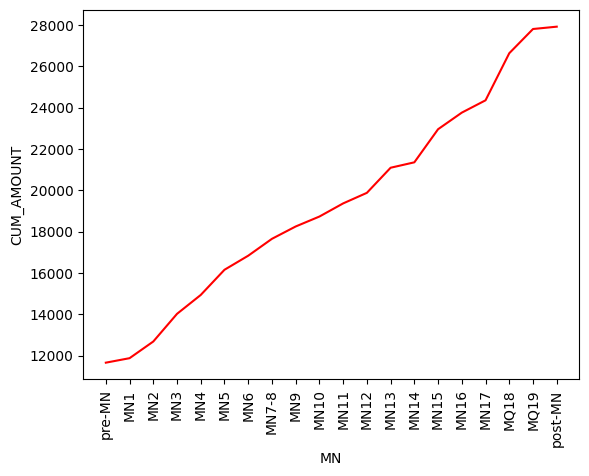

In [71]:
g = sns.lineplot(data=df_2, x='MN', y='CUM_AMOUNT', c='red')
temp = plt.setp(g.get_xticklabels(), rotation=90)

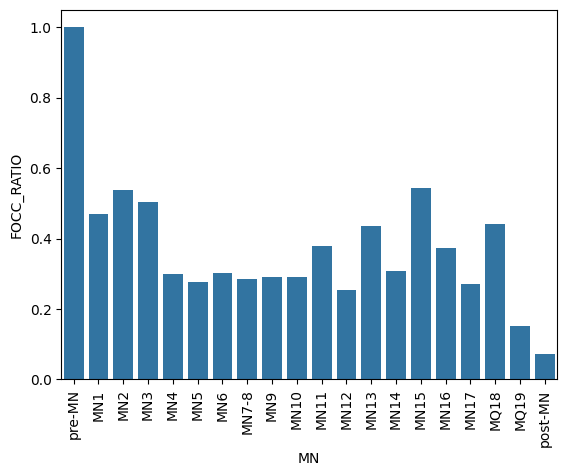

In [72]:
g = sns.barplot(data=df_2, x='MN', y='FOCC_RATIO')
temp = plt.setp(g.get_xticklabels(), rotation=90)

COMMENT:
    I dont really understand how the instructions went from one step at a time to two dataframes and plots. This also made it harder to follow and completly understand what is wanted.

Exercise 5. a) Create a DataFrame that collects the following information for every locality: locality number (LIDNUM), longitude, latitude,
    time unit, number of first occurrences in the locality, number of all occurrences in the locality and proportion of first occurrences in the locality.
    Note, you should use LIDNUM to identify unique localities and not the
    NAME variable (why?).

In [73]:
temp = df.copy()
df_3 = temp[['LIDNUM', 'LAT','LONG', 'MN', 'FOCC_TRUE', 'MN_INDEX']].groupby(['LIDNUM','MN', 'MN_INDEX','LAT','LONG'], sort=False).agg(
    FOCC_amount = pd.NamedAgg(column='FOCC_TRUE', aggfunc='sum'),
    TOTAL_amount = pd.NamedAgg(column='FOCC_TRUE', aggfunc='size')
).reset_index()
df_3.sort_values(by='MN_INDEX',ascending=True, inplace=True)
df_3['FOCC_RATIO'] = df_3['FOCC_amount'] / df_3['TOTAL_amount']
df_3



LIDNUM       MN  MN_INDEX        LAT        LONG  FOCC_amount  \
0      22564   pre-MN         0  50.433000    3.750000           13   
688    27904   pre-MN         0  47.934600    8.937800           10   
689    27905   pre-MN         0  47.934600    8.937800           12   
690    29053   pre-MN         0  47.934444    8.937778            3   
691    28815   pre-MN         0  48.935721   10.868547            1   
...      ...      ...       ...        ...         ...          ...   
6905   26511  post-MN        19  56.010000   92.800000            0   
6906   27074  post-MN        19  42.000000   42.000000            0   
6907   26757  post-MN        19  45.095361   23.027427            0   
6896   22546  post-MN        19  42.800000  132.800000            0   
7046   29405  post-MN        19   5.293111   35.876056            7   

      TOTAL_amount  FOCC_RATIO  
0               13    1.000000  
688             10    1.000000  
689             12    1.000000  
690              3    1.000000  
691              1    1.000000  
...            ...         ...  
6905             3    0.000000  
6906             6    0.000000  
6907             7    0.000000  
6896            10    0.000000  
7046            55    0.127273  

[7047 rows x 8 columns]

b) Visualize the distribution of localities in space and time. For each time
unit, plot the LAT and LONG coordinates of each locality (corresponding
to the time unit). For example, you can use the above codes to create a
geographic map and then use a standard matplotlib scatter plot to add
the localities. Choose the marker size for each locality such that it is
relative to the number of occurrences in the locality (bigger markers for
bigger localities).


c:\Users\hynni\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\hynni\AppData\Local\Temp\ipykernel_17412\52665001.py:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


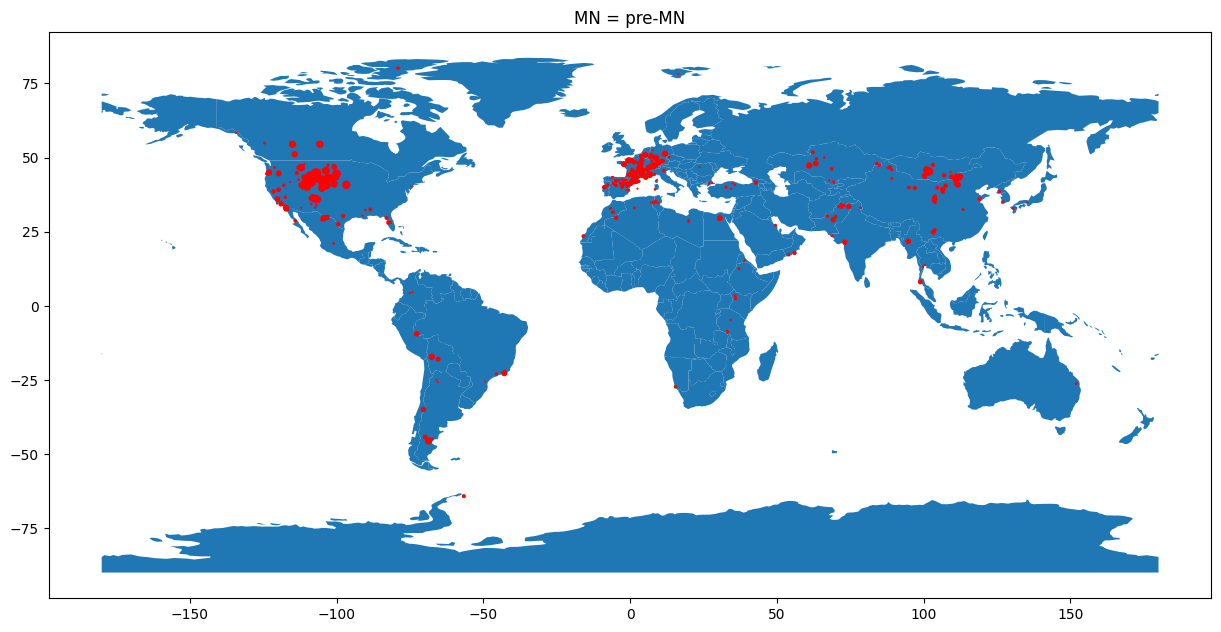

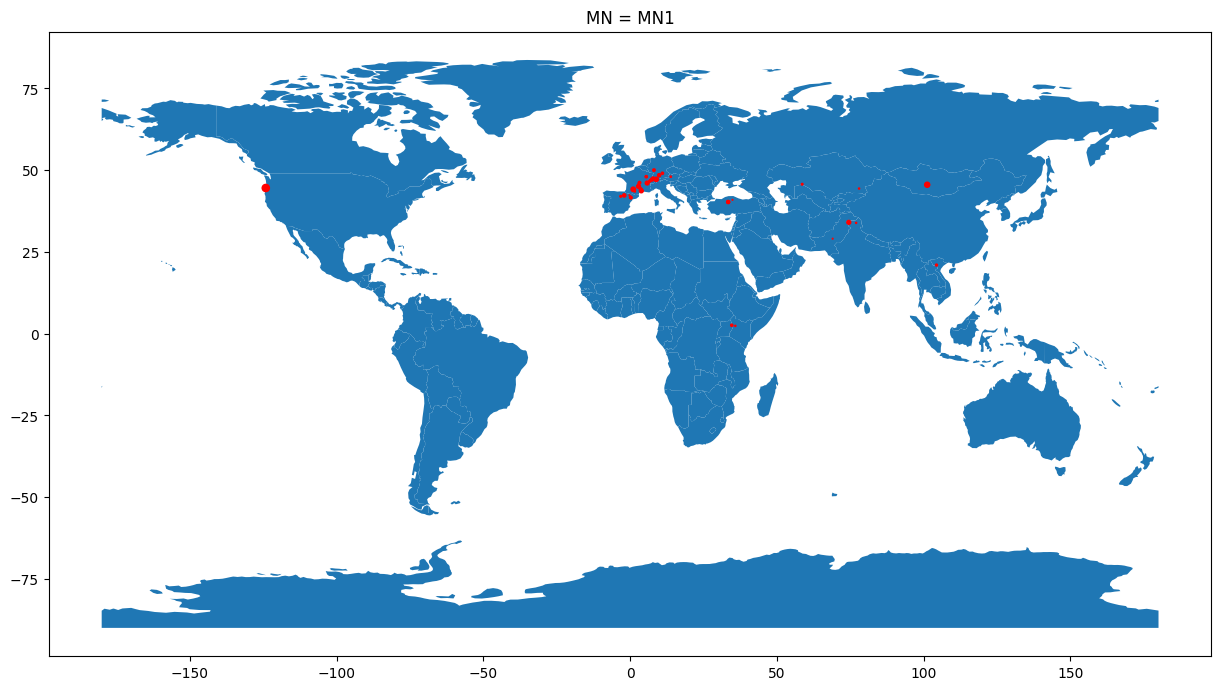

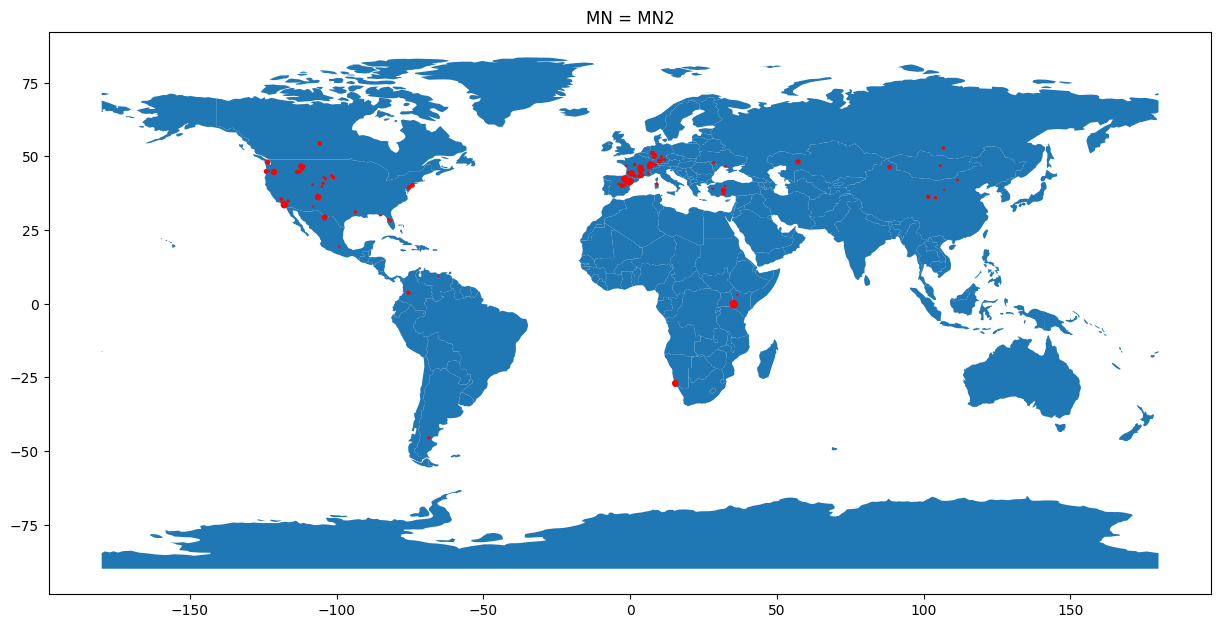

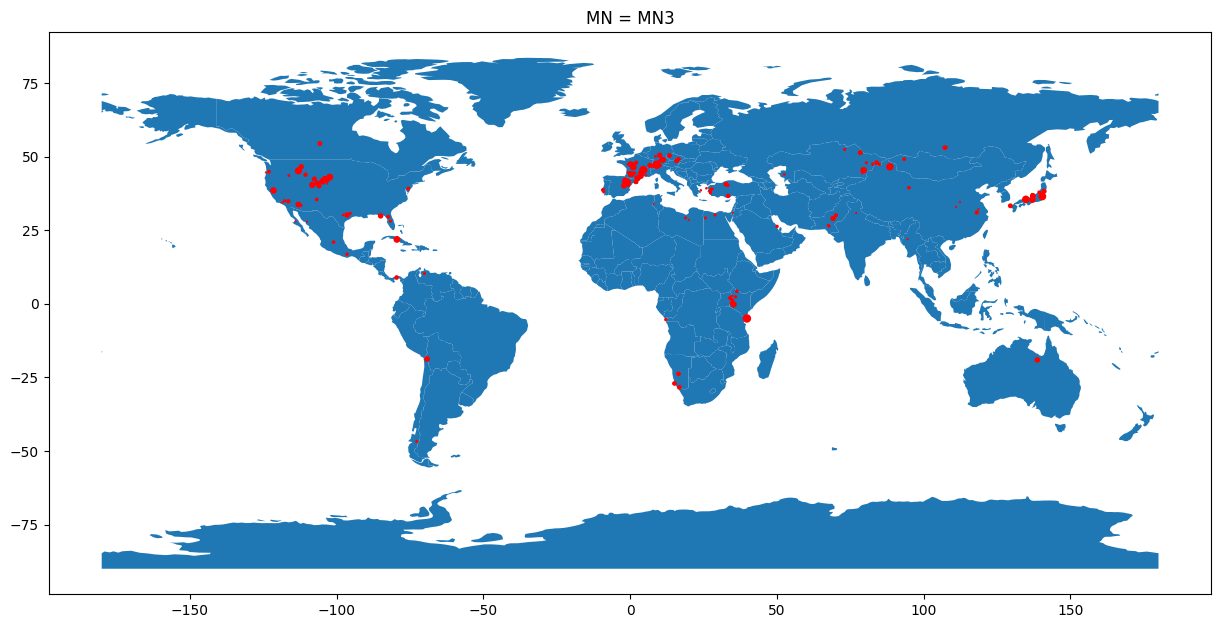

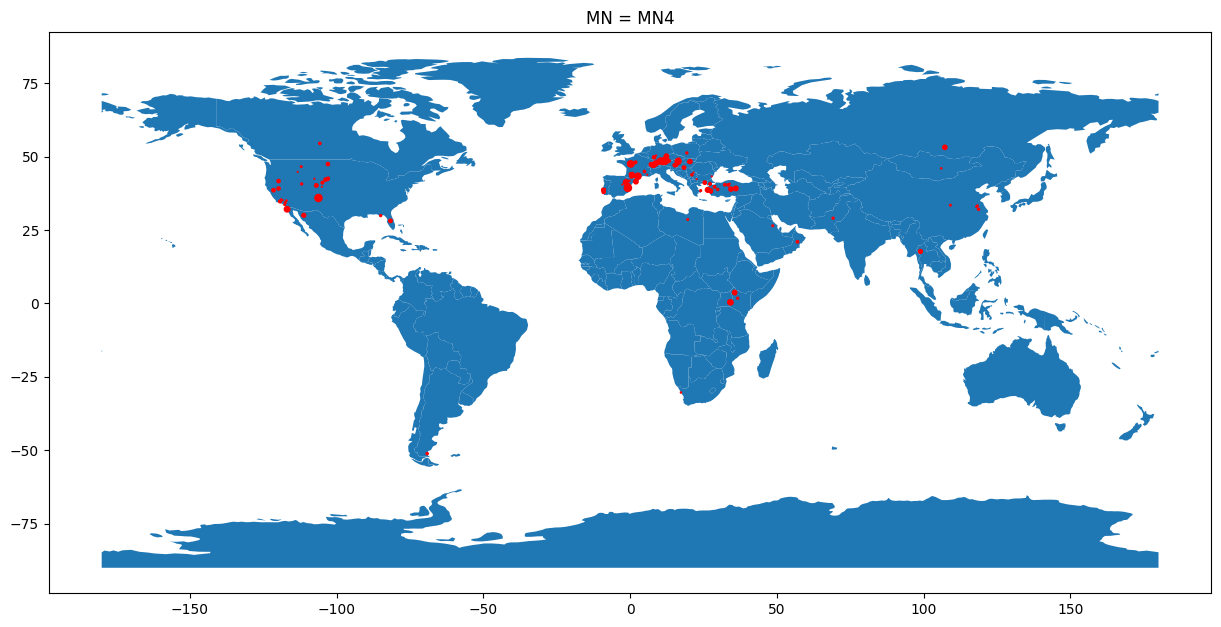

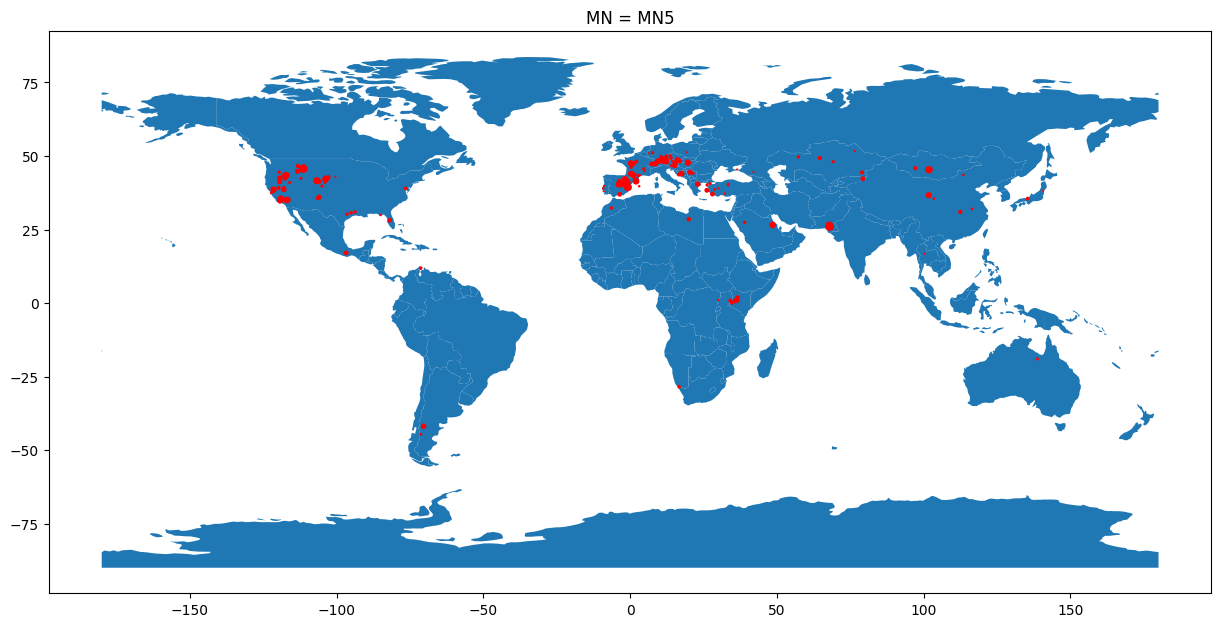

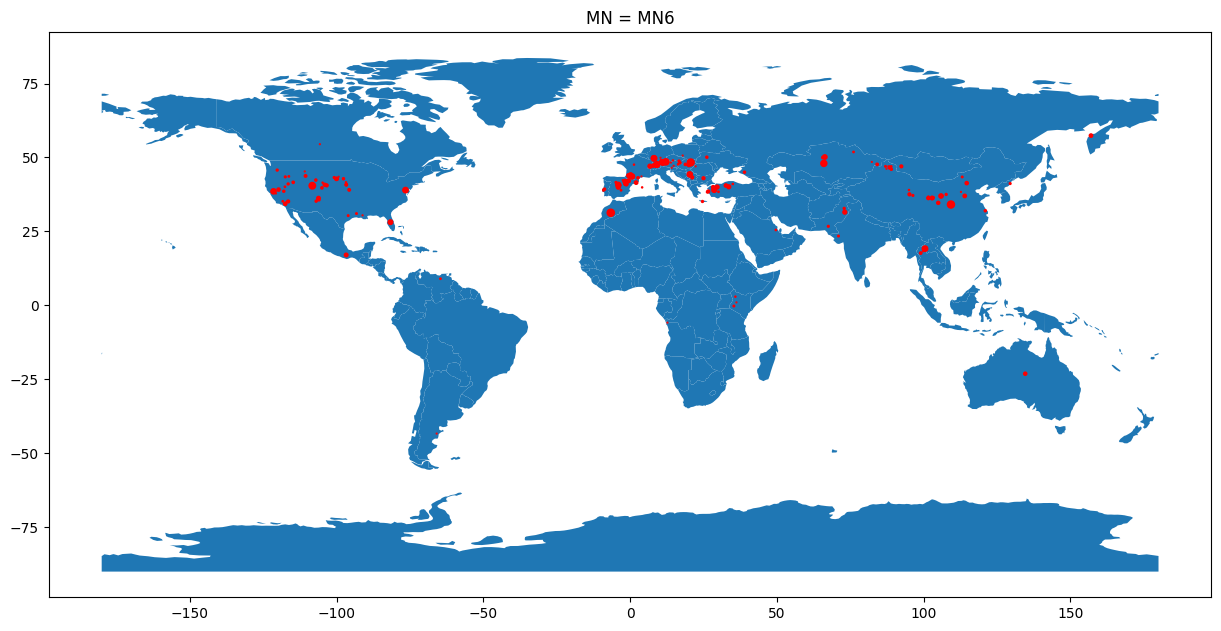

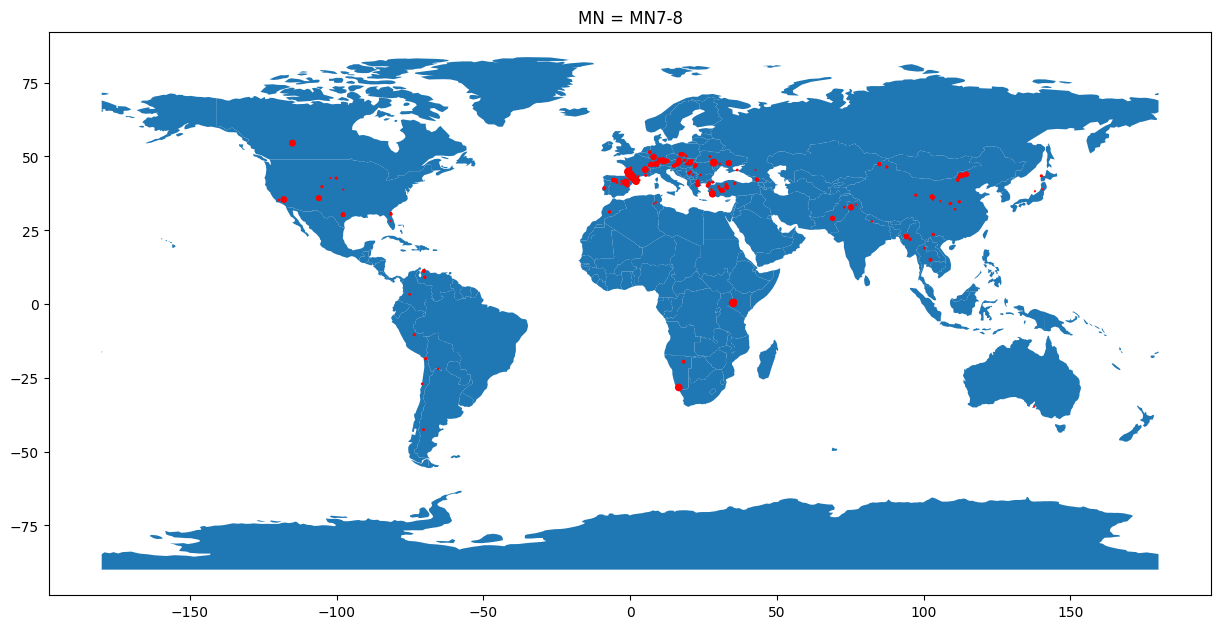

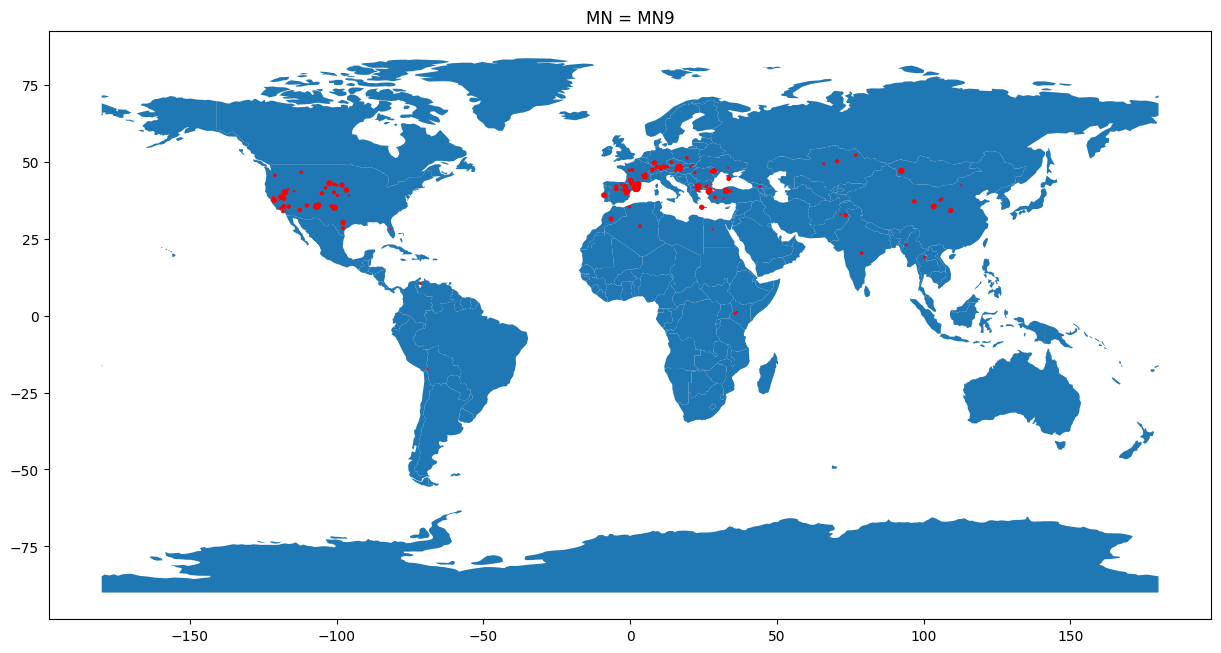

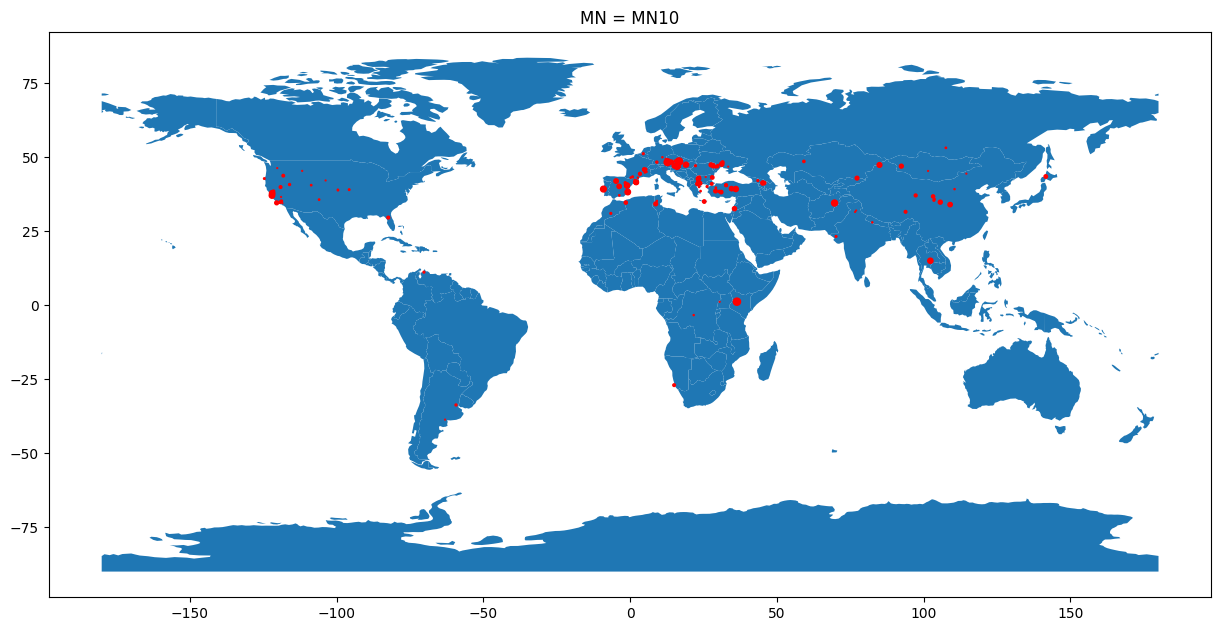

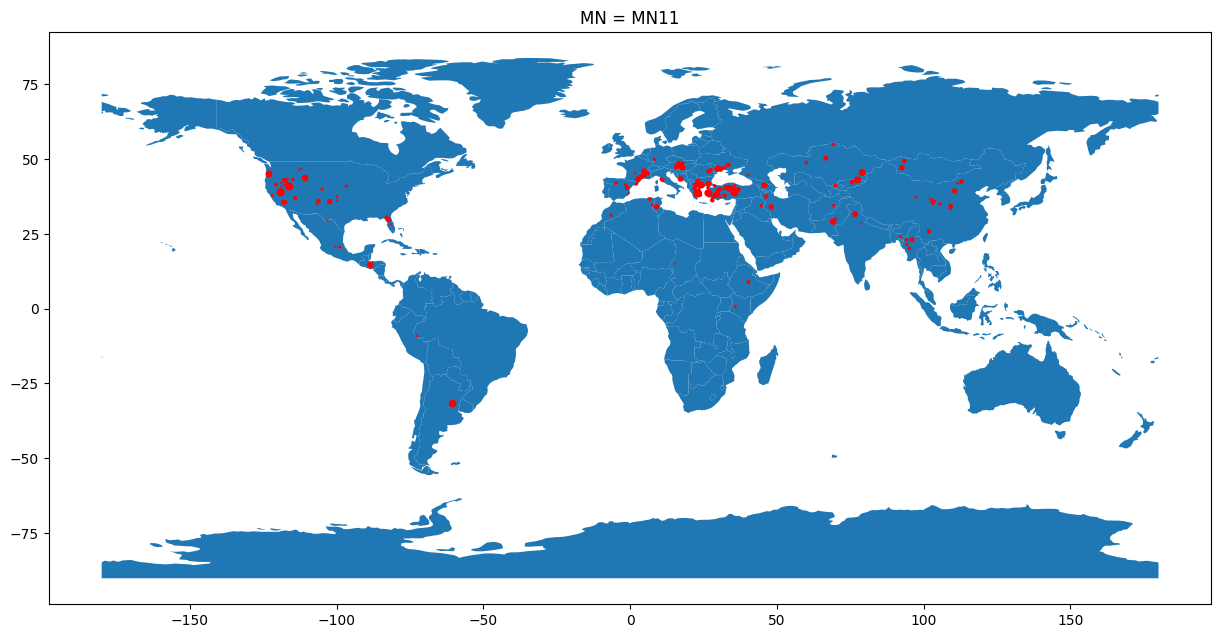

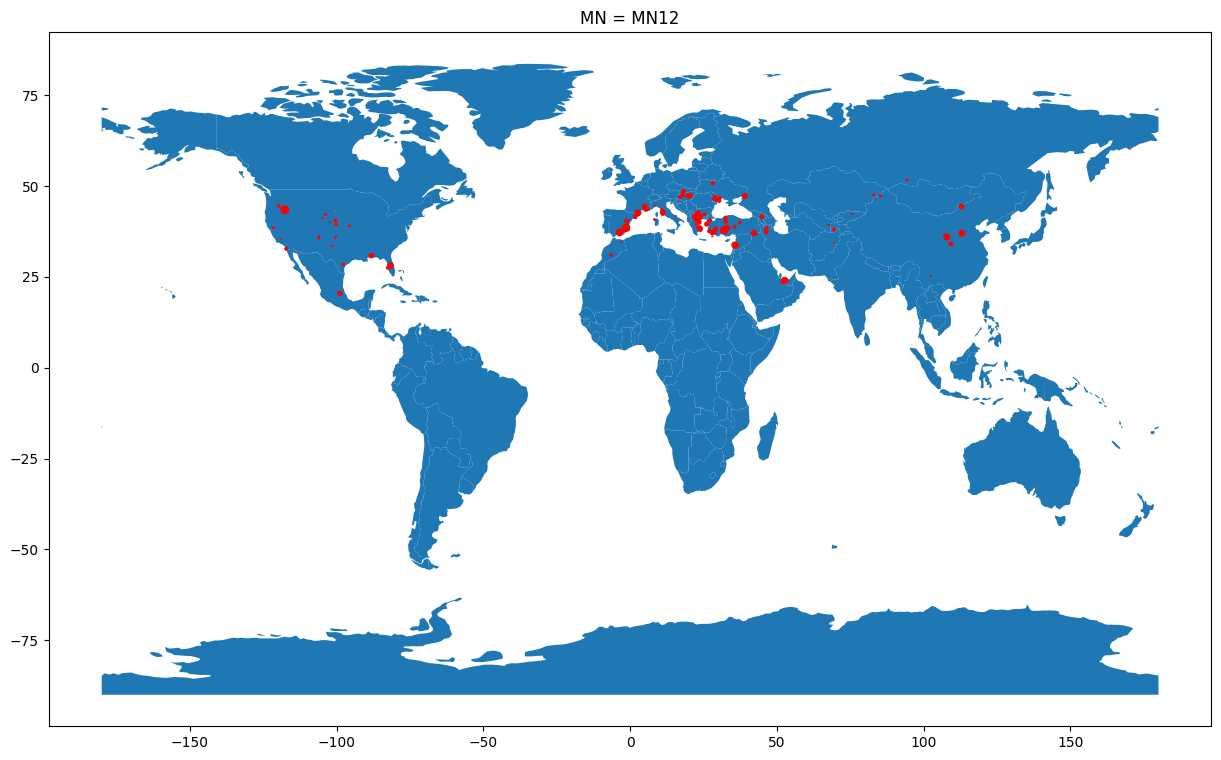

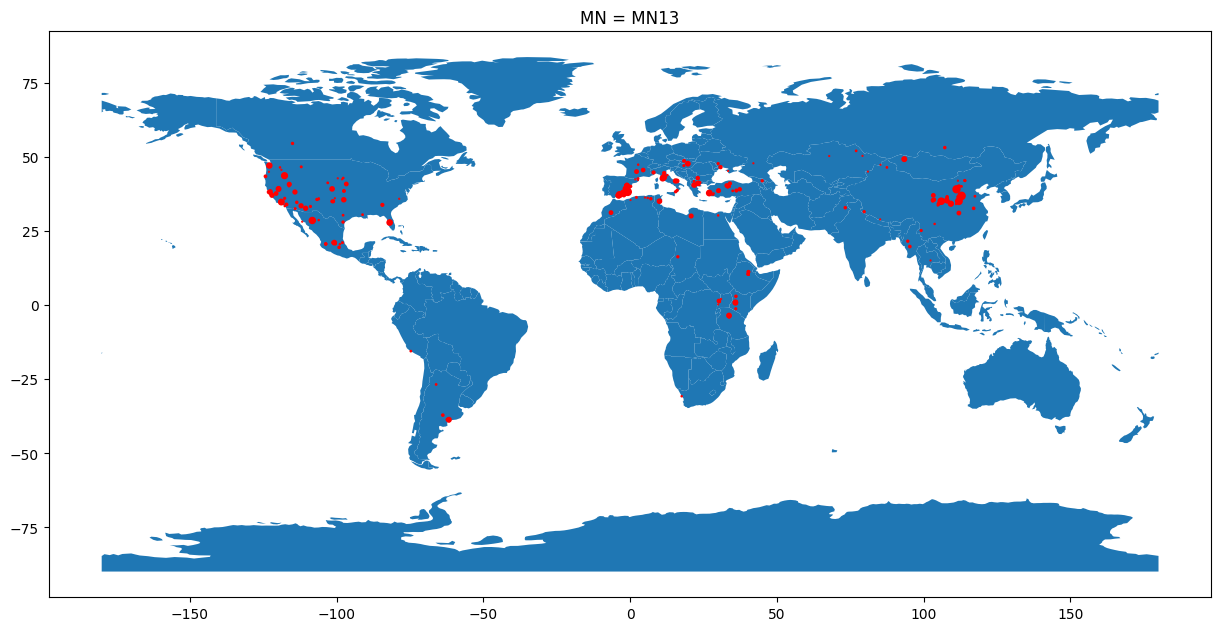

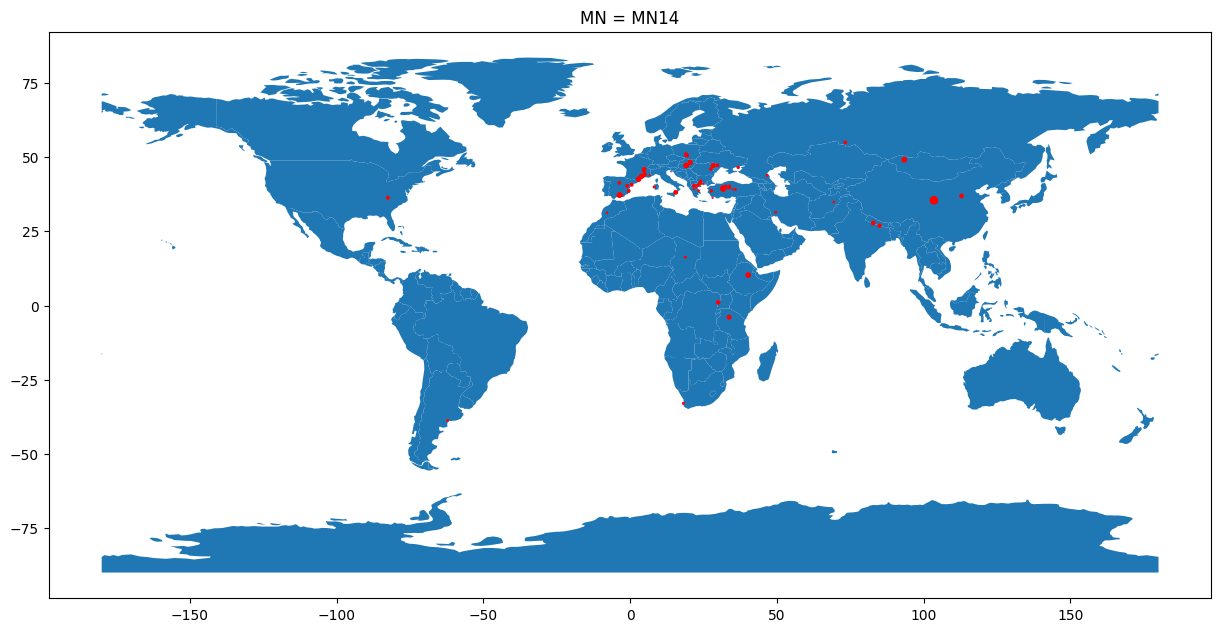

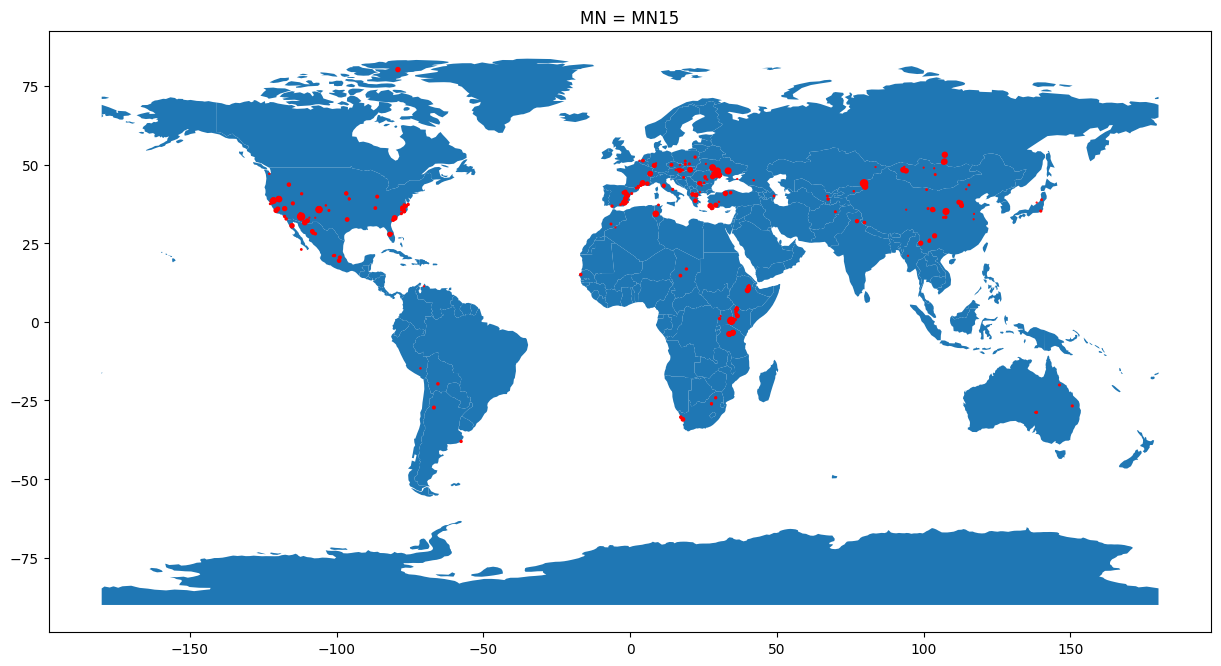

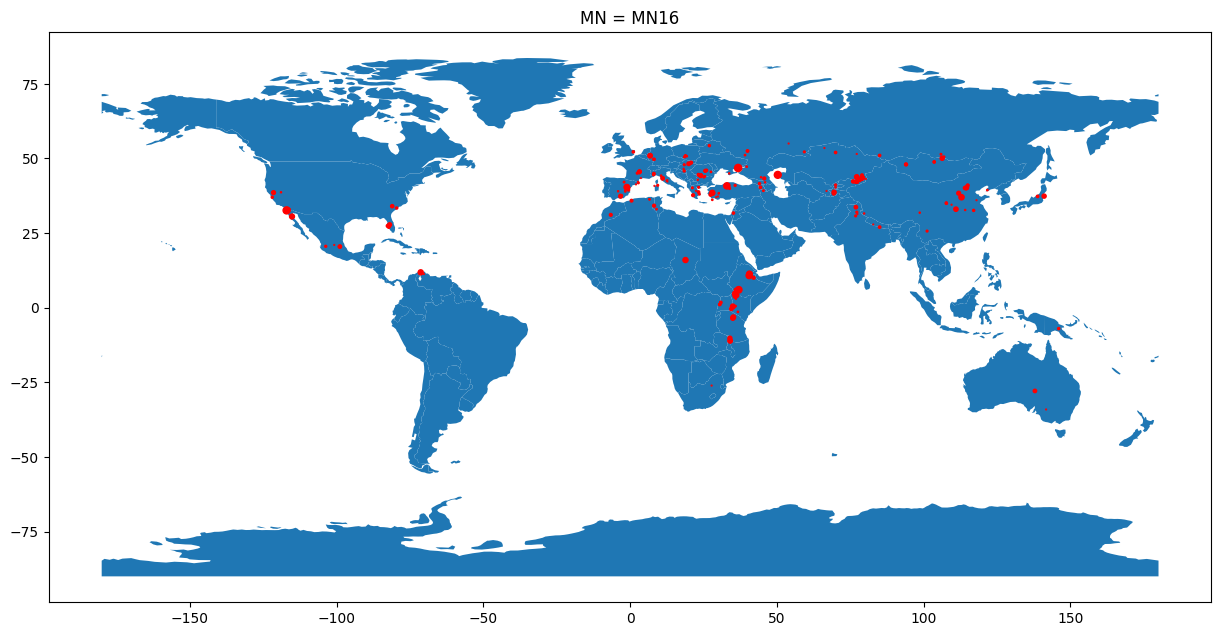

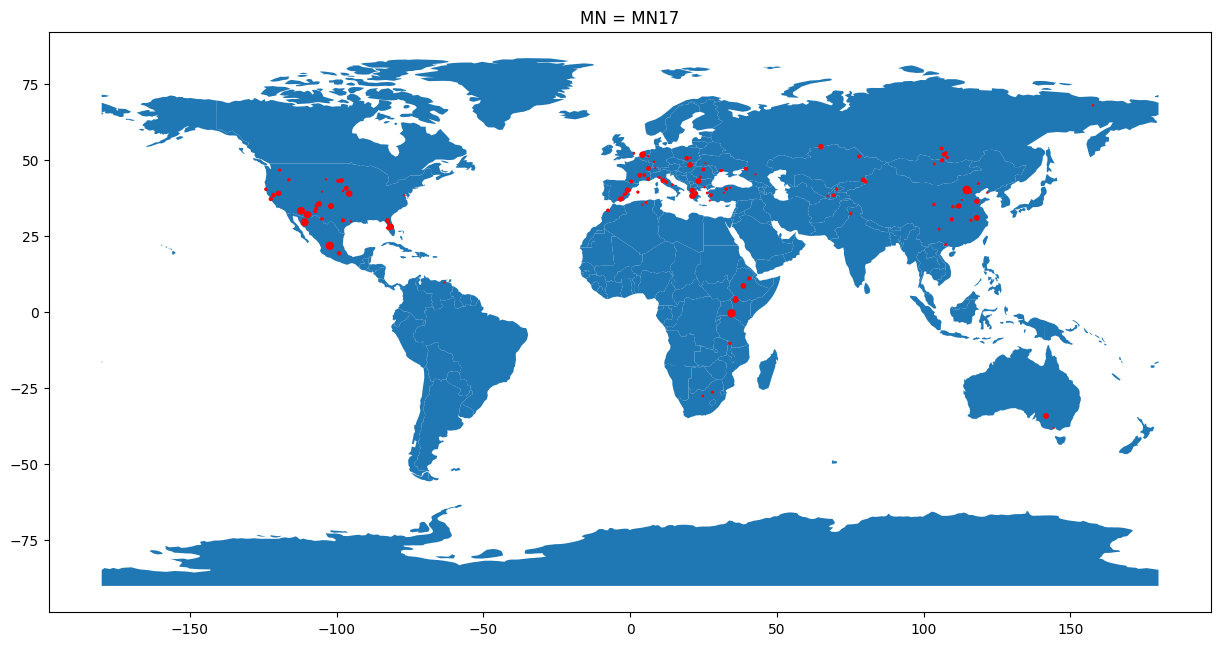

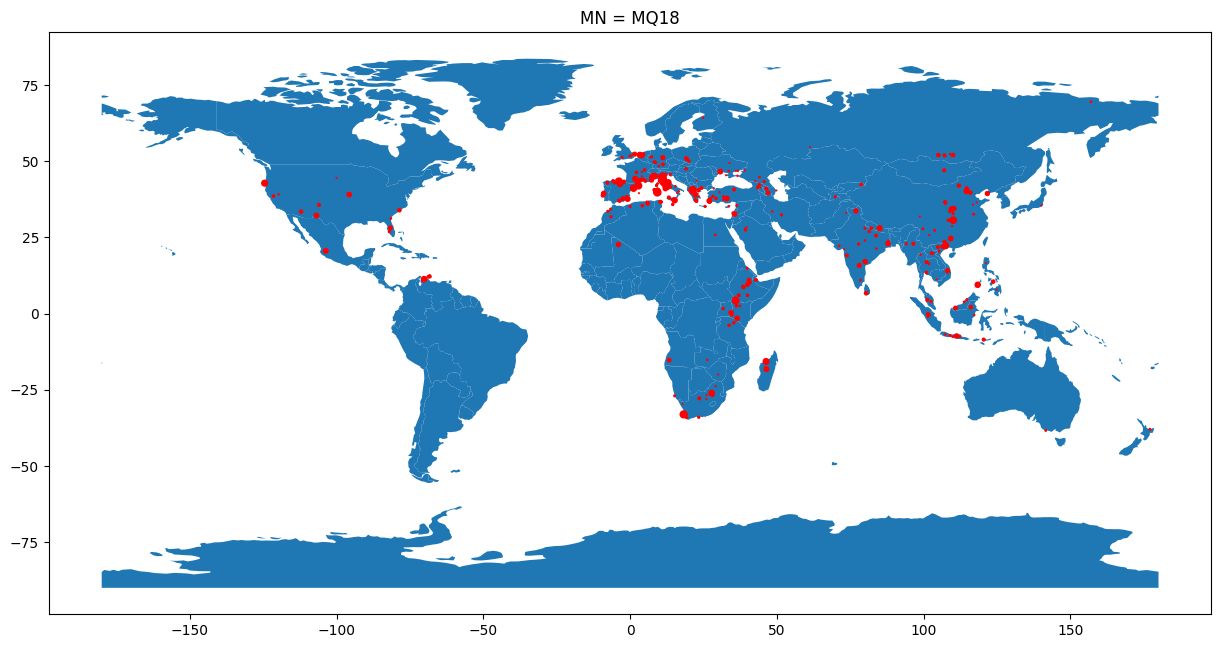

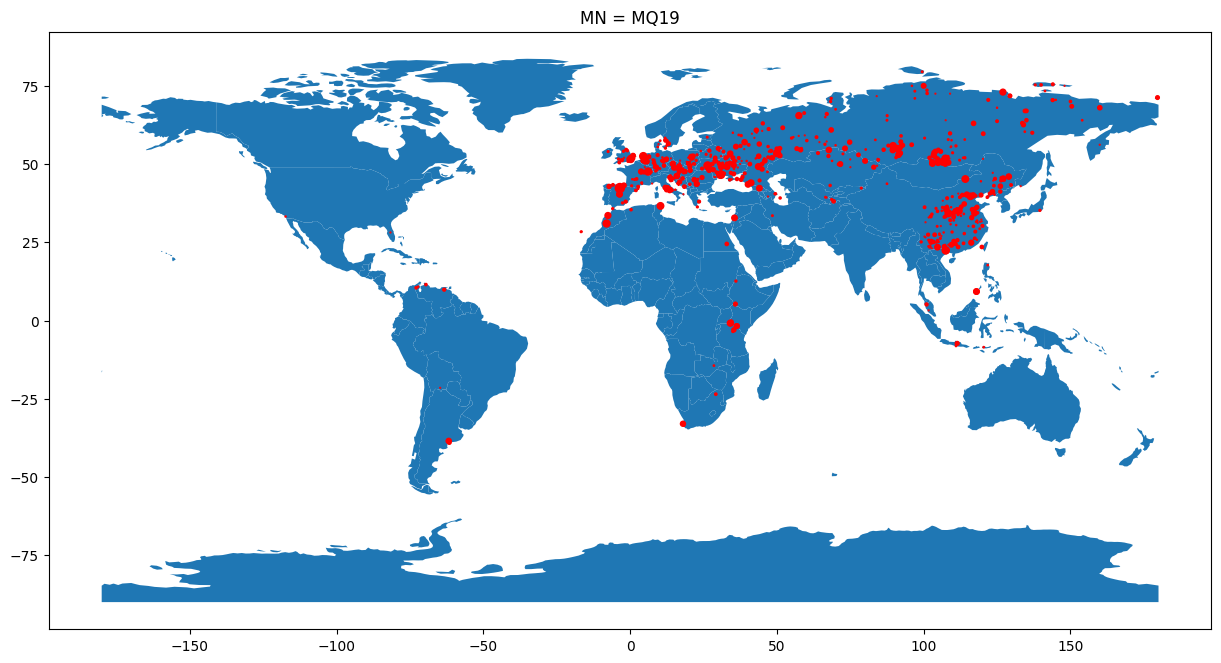

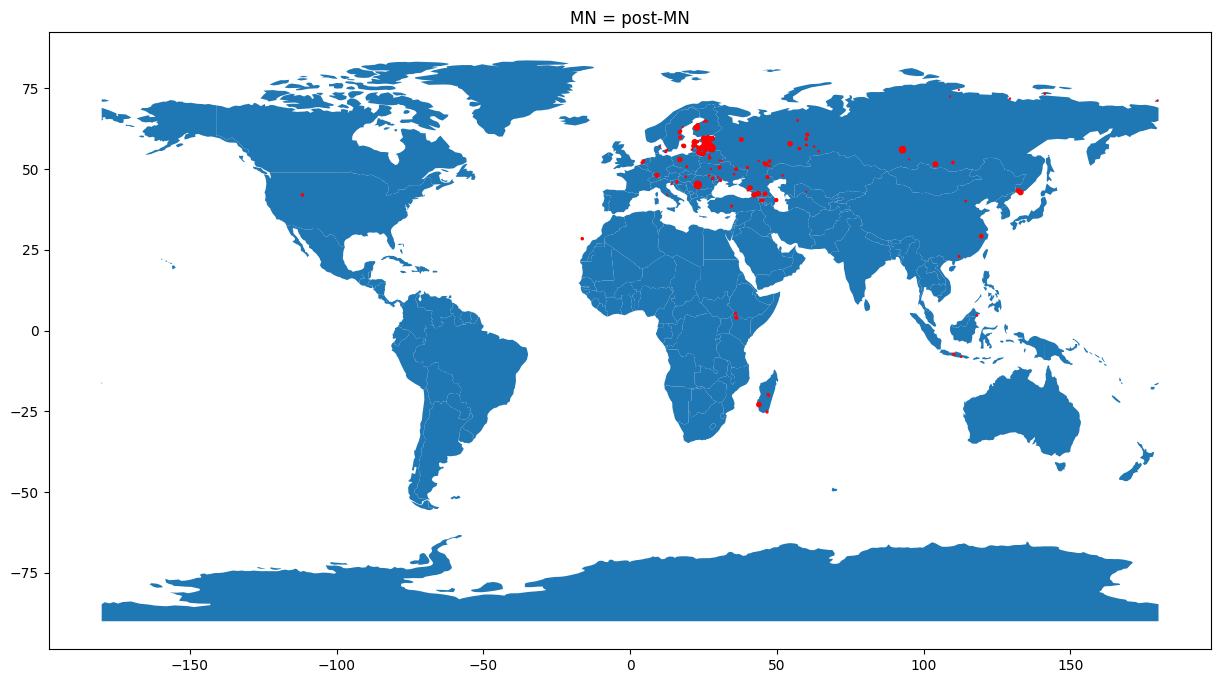

In [74]:

geometry = [Point(xy) for xy in zip(df_3['LONG'], df_3['LAT'])]
crs = {'init':'epsg:4326'}
geo_df = gpd.GeoDataFrame(df_3, #specify our data
                          crs=crs, #specify our coordinate reference system
                          geometry=geometry) #specify the geometry list we created
geo_df.head()

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

for t in geo_df['MN'].unique():
    fig, ax = plt.subplots(figsize=(15, 10))
    world.plot(ax=ax)
    geo_df[geo_df['MN'] == t].plot(ax=ax, 
                                        markersize=geo_df['TOTAL_amount']/3, 
                                        color='red', 
                                        marker='o',
            
                                        )
    ax.set_title(f'MN = {t}')
    plt.show()

c) Based on exercises 4 and 5, what kind of observations about sampling
can you make? Are there differences in sampling density over space and
time? Compare some basic sampling properties between Africa, Asia and
Europe, e.g. spatial coverage and average number of occurrences per
locality.


There are clear differences while observing the world map trough different time periods. Firstly from the 4th excercise we can spot that the first observations are not constant and for example pre-mn has the most first observations and post-mn the least. But even between the main periods there are huge differences between the amount of first observations. One that was stranges that the only categories that are merged together(7 and 8) have about the same amount of first obvservations than others periods near them. 

There were also differences between the distribution between continents in different time periods. Eurasia had notable amount of first observations in every time period unlike any other continent, specially Europe. Which could be result of somekind of bias. There we also some notable groups that were interesting. Because I dont really have prior knowledge about fossils and science around it I cant make better conclusions.

Exercise 6. For each locality, look at a ten by ten degrees area (in
latitude and longitude) centered around the locality. Record the total
number of occurrences and total number of first occurrences found within
that square in the time unit corresponding to the focal locality. Also,
record the total number of occurrences within that square in the preceding
time unit (relative to the focal locality). Record these numbers into the
DataFrame that was created in exercise 5 (add new columns).


In [75]:
def count10x10(row):
    c1 = (row['MN'] == df_3['MN'])
    c2 = ((df_3['LAT']-5 < row['LAT']) & (row['LAT'] < df_3['LAT']+5))
    c3 = ((df_3['LONG']-5 < row['LONG']) & (row['LONG'] < df_3['LONG']+5))
    return (df_3.loc[c1 & c2 & c3, 'FOCC_amount'].sum(), df_3.loc[c1 & c2 & c3, 'TOTAL_amount'].sum())


df_3[['10x10_FOCC','10x10_TOTAL']] = df_3.apply(count10x10, axis=1, result_type='expand')
df_3

LIDNUM       MN  MN_INDEX        LAT        LONG  FOCC_amount  \
0      22564   pre-MN         0  50.433000    3.750000           13   
688    27904   pre-MN         0  47.934600    8.937800           10   
689    27905   pre-MN         0  47.934600    8.937800           12   
690    29053   pre-MN         0  47.934444    8.937778            3   
691    28815   pre-MN         0  48.935721   10.868547            1   
...      ...      ...       ...        ...         ...          ...   
6905   26511  post-MN        19  56.010000   92.800000            0   
6906   27074  post-MN        19  42.000000   42.000000            0   
6907   26757  post-MN        19  45.095361   23.027427            0   
6896   22546  post-MN        19  42.800000  132.800000            0   
7046   29405  post-MN        19   5.293111   35.876056            7   

      TOTAL_amount  FOCC_RATIO  10x10_FOCC  10x10_TOTAL  
0               13    1.000000         898          898  
688             10    1.000000        1193         1193  
689             12    1.000000        1193         1193  
690              3    1.000000        1193         1193  
691              1    1.000000         944          944  
...            ...         ...         ...          ...  
6905             3    0.000000           1           95  
6906             6    0.000000           4          181  
6907             7    0.000000           0           41  
6896            10    0.000000           1          129  
7046            55    0.127273           8           66  

[7047 rows x 10 columns]

In [76]:
def count10x10_pre(row):
    index = row['MN_INDEX']-1
    if index < 0:return (0,0)
    c1 = (df_3['MN_INDEX'] == index)
    c2 = ((df_3['LAT']-5 < row['LAT']) & (row['LAT'] < df_3['LAT']+5))
    c3 = ((df_3['LONG']-5 < row['LONG']) & (row['LONG'] < df_3['LONG']+5))

    focc = df_3.loc[c1 & c2 & c3, 'FOCC_amount'].sum()
    total = df_3.loc[c1 & c2 & c3, 'TOTAL_amount'].sum()
    return focc, total

df_3[['10x10_FOCC_PRE','10x10_TOTAL_PRE']] = df_3.apply(count10x10_pre, axis=1, result_type='expand')
df_3

LIDNUM       MN  MN_INDEX        LAT        LONG  FOCC_amount  \
0      22564   pre-MN         0  50.433000    3.750000           13   
688    27904   pre-MN         0  47.934600    8.937800           10   
689    27905   pre-MN         0  47.934600    8.937800           12   
690    29053   pre-MN         0  47.934444    8.937778            3   
691    28815   pre-MN         0  48.935721   10.868547            1   
...      ...      ...       ...        ...         ...          ...   
6905   26511  post-MN        19  56.010000   92.800000            0   
6906   27074  post-MN        19  42.000000   42.000000            0   
6907   26757  post-MN        19  45.095361   23.027427            0   
6896   22546  post-MN        19  42.800000  132.800000            0   
7046   29405  post-MN        19   5.293111   35.876056            7   

      TOTAL_amount  FOCC_RATIO  10x10_FOCC  10x10_TOTAL  10x10_FOCC_PRE  \
0               13    1.000000         898          898               0   
688             10    1.000000        1193         1193               0   
689             12    1.000000        1193         1193               0   
690              3    1.000000        1193         1193               0   
691              1    1.000000         944          944               0   
...            ...         ...         ...          ...             ...   
6905             3    0.000000           1           95              41   
6906             6    0.000000           4          181              39   
6907             7    0.000000           0           41              56   
6896            10    0.000000           1          129               8   
7046            55    0.127273           8           66               4   

      10x10_TOTAL_PRE  
0                   0  
688                 0  
689                 0  
690                 0  
691                 0  
...               ...  
6905              283  
6906              223  
6907              598  
6896               40  
7046               30  

[7047 rows x 12 columns]

Exercise 7. a) Create the regression data set. Only use localities within
the co-ordinates -25<LONG<40 and LAT>35 and time unit within MN2-
MQ19 (why not include MN1?). Create an m × 2 array, where m is the
total number of occurrences in all the localities. Each row in the array
represents one occurrence. For each occurrence, fill in to the first column
of the array the number of occurrences in the focal area in the previous
time unit (calculated in exercise 6). For the second column, fill in 1 for a
first occurrence and 0 for other occurrences.
b) Perform logistic regression.
c) Plot regression curve and 95%-confidence intervals.


In [77]:
df_r = df.loc[(-25 < df['LONG']) & (df['LONG'] < 40) & (df['LAT'] > 35) &
                (df['MN_INDEX'] > 1) & (df['MN_INDEX'] < 19)]
df_r = pd.merge(df_r, df_3, on=['MN', 'LIDNUM'])
df_r = df_r[['10x10_TOTAL_PRE', 'FOCC_TRUE']]
df_r['FOCC_TRUE'] = df_r['FOCC_TRUE'].astype(int)
df_r

10x10_TOTAL_PRE  FOCC_TRUE
0                  314          1
1                 1408          1
2                  799          1
3                  799          1
4                  434          1
...                ...        ...
26118                0          0
26119                0          0
26120                0          0
26121                0          0
26122                0          0

[26123 rows x 2 columns]

In [78]:
X = df_r['10x10_TOTAL_PRE']
y = df_r['FOCC_TRUE']

X = sm.add_constant(X)
model = sm.Logit(y, X)
result = model.fit()


coef = result.params
conf95 = result.conf_int(alpha=0.05)


print(coef)
print(conf95)


Optimization terminated successfully.
         Current function value: 0.568592
         Iterations 5
const             -0.829473
10x10_TOTAL_PRE   -0.000589
dtype: float64
                        0         1
const           -0.870624 -0.788322
10x10_TOTAL_PRE -0.000675 -0.000504


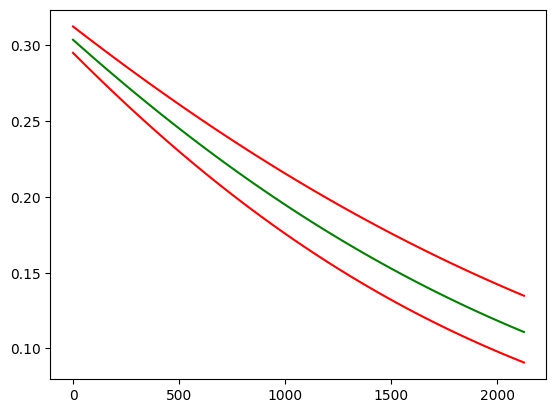

In [79]:
def logf(x, c0, c1):
    return 1/(1+np.exp(-c0-c1*x))



X_pred = np.linspace(df_r['10x10_TOTAL_PRE'].min(), df_r['10x10_TOTAL_PRE'].max(), 100)
y_pred = logf(X_pred, coef[0], coef[1])
y95low_pred = logf(X_pred, conf95[0][0], conf95[0][1])
y95up_pred = logf(X_pred, conf95[1][0], conf95[1][1])


sns.lineplot(x=X_pred, y=y_pred, c='green')
sns.lineplot(x=X_pred, y=y95low_pred, c='red')
sns.lineplot(x=X_pred, y=y95up_pred, c='red')

plt.show()


Exercise 8. For each European locality, calculate the expected propor-
tion of rst occurrences in the focal area surrounding the locality using
the logistic regression calculated in exercise 7.

In [80]:
df_europe = df_3.loc[(-25 < df_3['LONG']) & (df_3['LONG'] < 40) & (df_3['LAT'] > 35) &
                (df_3['MN_INDEX'] > 1) & (df_3['MN_INDEX'] < 19)]
df_europe["10x10_EXPECTED_FOCC"] = logf(df_europe["10x10_TOTAL_PRE"],coef[0], coef[1])
df_europe

LIDNUM    MN  MN_INDEX        LAT       LONG  FOCC_amount  TOTAL_amount  \
1305   21514   MN2         2  42.055000  -0.572000            6             7   
1281   27802   MN2         2  47.021851   7.147846            1             1   
1282   27495   MN2         2  44.486917  -0.444767            2             2   
1283   21306   MN2         2  48.920000  11.862000            1             1   
1284   28930   MN2         2  47.214990   7.211480            1             4   
...      ...   ...       ...        ...        ...          ...           ...   
6248   21867  MQ19        18  52.217000  20.950000            0             1   
6250   21971  MQ19        18  51.100000  17.033000            0             2   
6252   29625  MQ19        18  36.620833  10.349444            6             6   
6255   21922  MQ19        18  59.300000  37.000000            1             2   
6265   22217  MQ19        18  48.400000  26.300000            0             3   

      FOCC_RATIO  10x10_FOCC  10x10_TOTAL  10x10_FOCC_PRE  10x10_TOTAL_PRE  \
1305    0.857143         198          454              70              186   
1281    1.000000         149          445              97              249   
1282    1.000000         208          475              70              186   
1283    1.000000          85          240              38               73   
1284    0.250000         149          445              97              249   
...          ...         ...          ...             ...              ...   
6248    0.000000          76          683              18               44   
6250    0.000000         105          898              18               44   
6252    1.000000          26           87              68              177   
6255    0.500000           8           38               0                0   
6265    0.000000          49          415              19               76   

      10x10_EXPECTED_FOCC  
1305             0.281090  
1281             0.273650  
1282             0.281090  
1283             0.294738  
1284             0.273650  
...                   ...  
6248             0.298302  
6250             0.298302  
6252             0.282163  
6255             0.303757  
6265             0.294371  

[3080 rows x 13 columns]

Exercise 9. For each European locality, calculate the probability of ob-
serving as many or more rst occurrences in the focal area than what is
actually found. Assume that occurrences are binomially distributed to
\rst occurrences" and \not rst occurrences", so that the probability of
a given occurrence to be a rst occurrence is equal to the expected pro-
portion of rst occurrences in the focal area. You may use, for example,
the scipy.stats.binom library (https://docs.scipy.org/doc/scipy-0.14.0/
reference/generated/scipy.stats.binom.html) for the calculations.

In [81]:
df_europe["p_value"] = stats.binom.sf(df_europe["10x10_FOCC"], df_europe["10x10_TOTAL"], df_europe["10x10_EXPECTED_FOCC"])
df_europe

LIDNUM    MN  MN_INDEX        LAT       LONG  FOCC_amount  TOTAL_amount  \
1305   21514   MN2         2  42.055000  -0.572000            6             7   
1281   27802   MN2         2  47.021851   7.147846            1             1   
1282   27495   MN2         2  44.486917  -0.444767            2             2   
1283   21306   MN2         2  48.920000  11.862000            1             1   
1284   28930   MN2         2  47.214990   7.211480            1             4   
...      ...   ...       ...        ...        ...          ...           ...   
6248   21867  MQ19        18  52.217000  20.950000            0             1   
6250   21971  MQ19        18  51.100000  17.033000            0             2   
6252   29625  MQ19        18  36.620833  10.349444            6             6   
6255   21922  MQ19        18  59.300000  37.000000            1             2   
6265   22217  MQ19        18  48.400000  26.300000            0             3   

      FOCC_RATIO  10x10_FOCC  10x10_TOTAL  10x10_FOCC_PRE  10x10_TOTAL_PRE  \
1305    0.857143         198          454              70              186   
1281    1.000000         149          445              97              249   
1282    1.000000         208          475              70              186   
1283    1.000000          85          240              38               73   
1284    0.250000         149          445              97              249   
...          ...         ...          ...             ...              ...   
6248    0.000000          76          683              18               44   
6250    0.000000         105          898              18               44   
6252    1.000000          26           87              68              177   
6255    0.500000           8           38               0                0   
6265    0.000000          49          415              19               76   

      10x10_EXPECTED_FOCC       p_value  
1305             0.281090  6.437052e-13  
1281             0.273650  1.903930e-03  
1282             0.281090  1.107973e-13  
1283             0.294738  1.962861e-02  
1284             0.273650  1.903930e-03  
...                   ...           ...  
6248             0.298302  1.000000e+00  
6250             0.298302  1.000000e+00  
6252             0.282163  3.162488e-01  
6255             0.303757  8.595111e-01  
6265             0.294371  1.000000e+00  

[3080 rows x 14 columns]

c:\Users\hynni\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\hynni\AppData\Local\Temp\ipykernel_17412\449612862.py:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
C:\Users\hynni\AppData\Local\Temp\ipykernel_17412\449612862.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length 

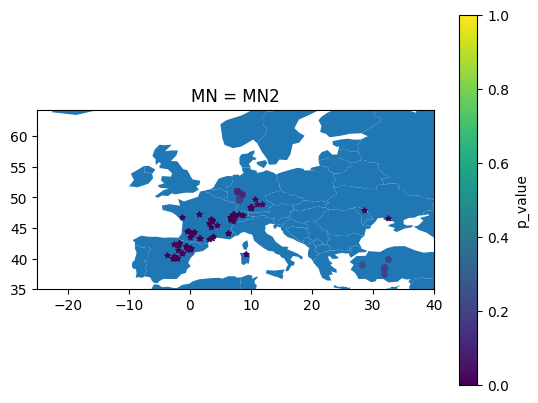

C:\Users\hynni\AppData\Local\Temp\ipykernel_17412\449612862.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(row.geometry.x, row.geometry.y,


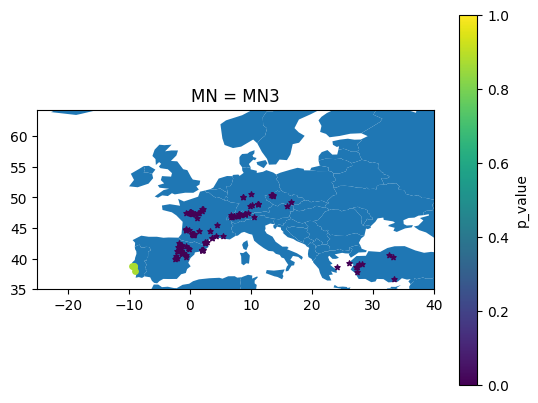

C:\Users\hynni\AppData\Local\Temp\ipykernel_17412\449612862.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(row.geometry.x, row.geometry.y,


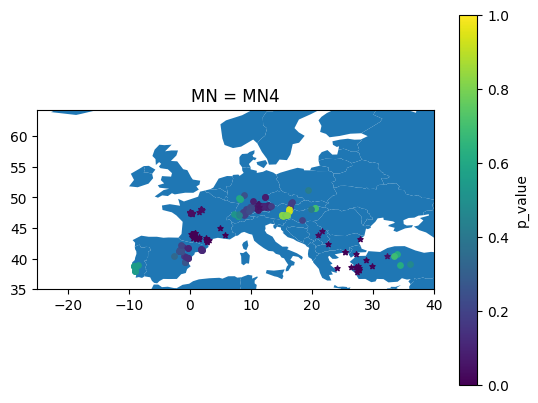

C:\Users\hynni\AppData\Local\Temp\ipykernel_17412\449612862.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(row.geometry.x, row.geometry.y,


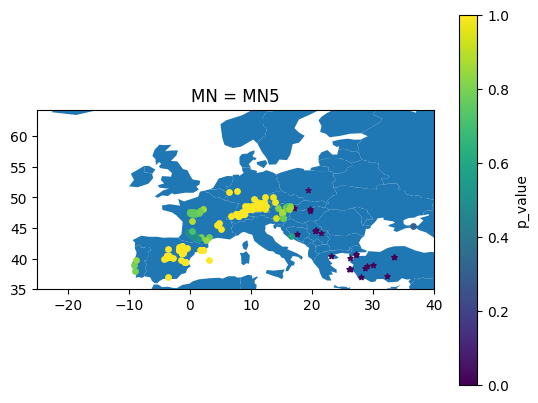

C:\Users\hynni\AppData\Local\Temp\ipykernel_17412\449612862.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(row.geometry.x, row.geometry.y,


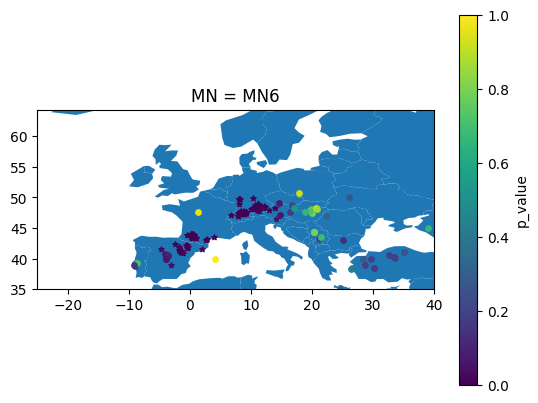

C:\Users\hynni\AppData\Local\Temp\ipykernel_17412\449612862.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(row.geometry.x, row.geometry.y,


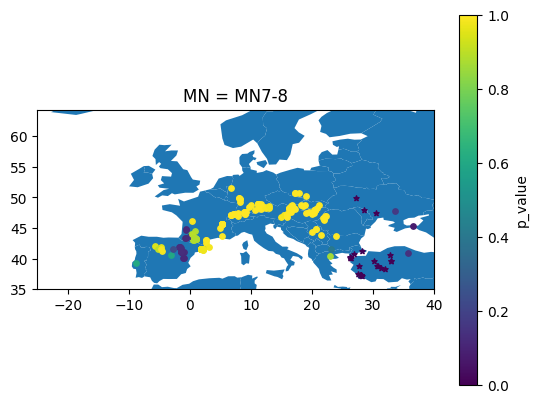

C:\Users\hynni\AppData\Local\Temp\ipykernel_17412\449612862.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(row.geometry.x, row.geometry.y,


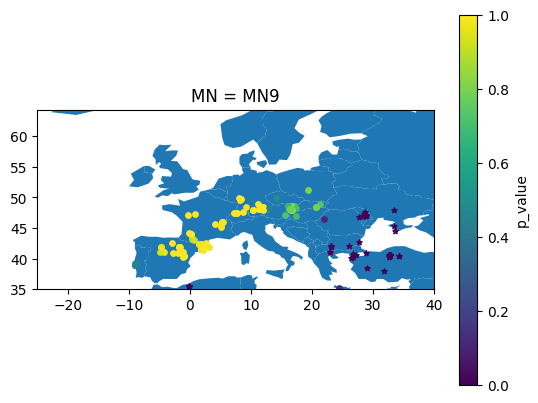

C:\Users\hynni\AppData\Local\Temp\ipykernel_17412\449612862.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(row.geometry.x, row.geometry.y,


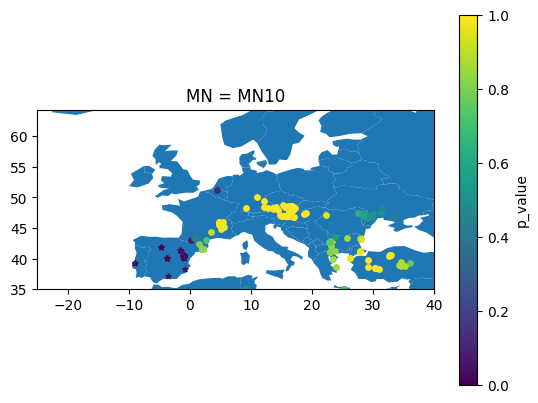

C:\Users\hynni\AppData\Local\Temp\ipykernel_17412\449612862.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(row.geometry.x, row.geometry.y,


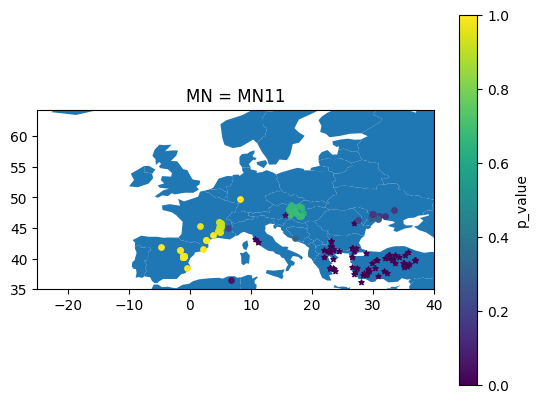

C:\Users\hynni\AppData\Local\Temp\ipykernel_17412\449612862.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(row.geometry.x, row.geometry.y,


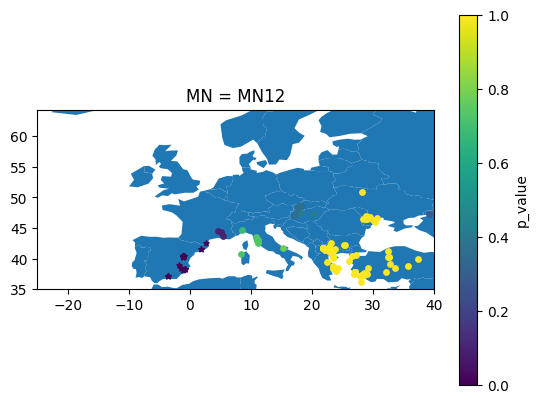

C:\Users\hynni\AppData\Local\Temp\ipykernel_17412\449612862.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(row.geometry.x, row.geometry.y,


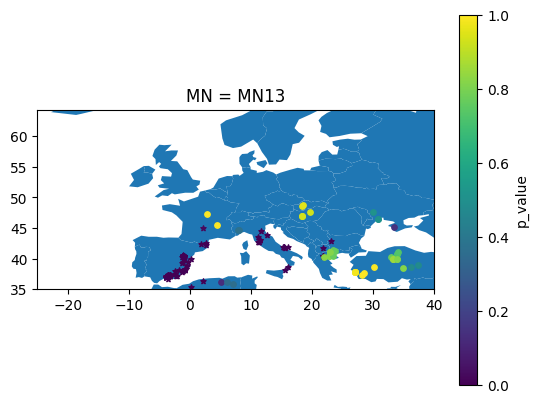

C:\Users\hynni\AppData\Local\Temp\ipykernel_17412\449612862.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(row.geometry.x, row.geometry.y,


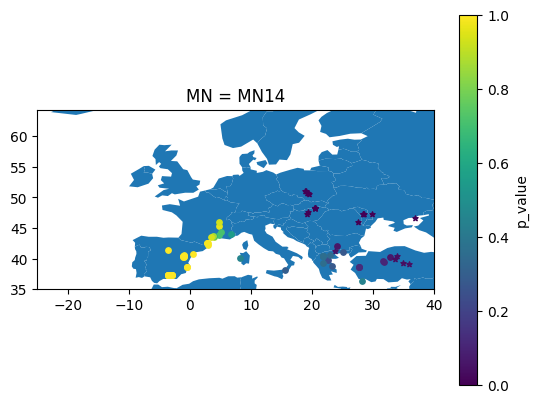

C:\Users\hynni\AppData\Local\Temp\ipykernel_17412\449612862.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(row.geometry.x, row.geometry.y,


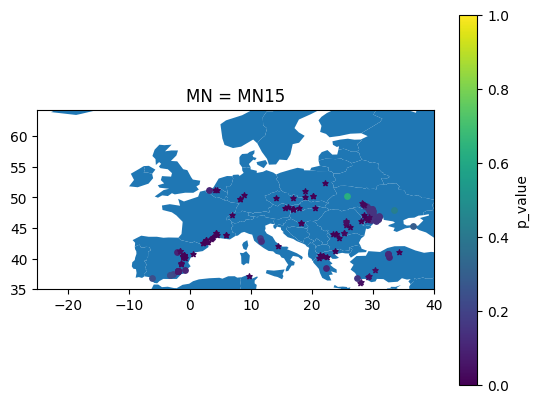

C:\Users\hynni\AppData\Local\Temp\ipykernel_17412\449612862.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(row.geometry.x, row.geometry.y,


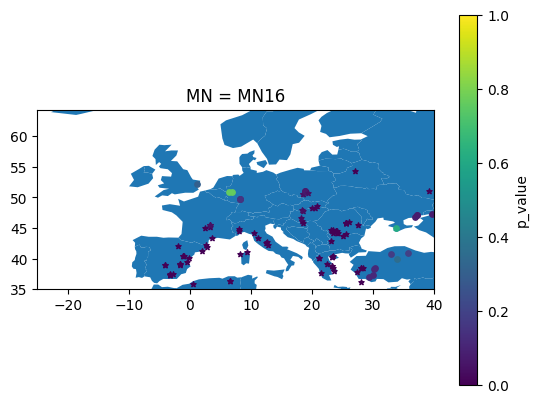

C:\Users\hynni\AppData\Local\Temp\ipykernel_17412\449612862.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(row.geometry.x, row.geometry.y,


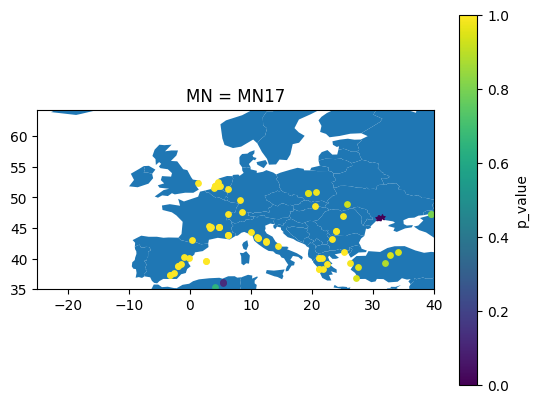

C:\Users\hynni\AppData\Local\Temp\ipykernel_17412\449612862.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(row.geometry.x, row.geometry.y,


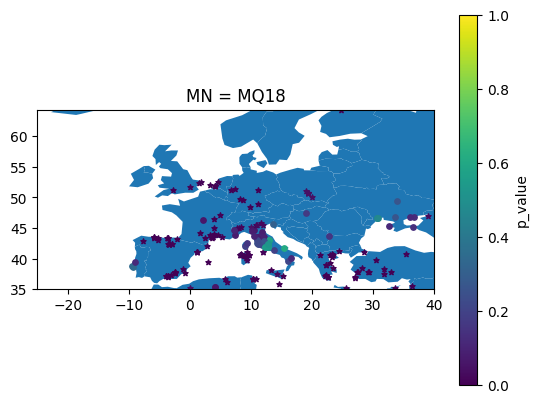

C:\Users\hynni\AppData\Local\Temp\ipykernel_17412\449612862.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(row.geometry.x, row.geometry.y,


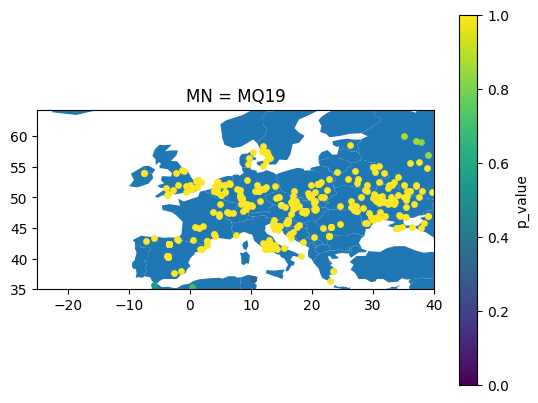

In [82]:
geometry = [Point(xy) for xy in zip(df_europe['LONG'], df_europe['LAT'])]
crs = {'init':'epsg:4326'}
geo_df = gpd.GeoDataFrame(df_europe, #specify our data
                          crs=crs, #specify our coordinate reference system
                          geometry=geometry) #specify the geometry list we created
geo_df.head()

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
norm = mcolors.Normalize(vmin=geo_df['p_value'].min(), vmax=geo_df['p_value'].max())
cmap = cm.ScalarMappable(norm=norm, cmap='viridis')

for t in geo_df['MN'].unique():
    fig, ax = plt.subplots()
    world.plot(ax=ax)
    geo_df[geo_df['MN'] == t].apply(lambda row: 
        ax.scatter(row.geometry.x, row.geometry.y,
                   s=15,
                   c=cmap.to_rgba(row['p_value']),
                   marker='*' if row['p_value'] <= 0.05 else 'o'),
        axis=1)
    ax.set_xlim(-25, 40)
    ax.set_ylim(35, geo_df['LAT'].max()) 
    ax.set_title(f'MN = {t}')
    cbar = plt.colorbar(cmap, ax=ax)
    cbar.set_label('p_value')
    plt.show()

We can clearly see pattern where some timeperiods have much more statistifically insignificant localities than others, and there are only few with both statistically significant and insignificant localities. More of then than not, the statistifically insignificant localities are also somehow grouped together specially in earlier periods.